# Computer Assignment 14: Advanced Deep Reinforcement Learning

## Topics Covered:
- **Offline Reinforcement Learning**: Learning from static datasets
- **Safe Reinforcement Learning**: Constraint satisfaction and risk management
- **Multi-Agent Reinforcement Learning**: Coordination and competition
- **Robust Reinforcement Learning**: Handling uncertainty and adversarial conditions
- **Real-World Applications**: Practical deployment considerations

## Learning Objectives:
1. Understand advanced RL paradigms beyond standard online learning
2. Implement offline RL algorithms for batch learning scenarios
3. Design safe RL agents with constraint satisfaction
4. Create multi-agent systems with coordination mechanisms
5. Build robust agents that handle uncertainty and distribution shifts
6. Apply advanced RL techniques to real-world scenarios

---
**Assignment Date**: Advanced Deep RL - Lesson 14  
**Estimated Time**: 3-4 hours  
**Difficulty**: Advanced  

In [1]:
# Advanced Deep RL - CA14 Setup and Imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Categorical, MultivariateNormal
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import deque, namedtuple
import random
import copy
import gym
from typing import List, Dict, Tuple, Optional, Union
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Configuration for advanced RL
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Advanced RL Constants
OFFLINE_RL_CONFIG = {
    'batch_size': 256,
    'buffer_size': 100000,
    'conservative_weight': 1.0,  # CQL parameter
    'behavior_cloning_weight': 0.1
}

SAFE_RL_CONFIG = {
    'constraint_threshold': 0.1,
    'lagrange_lr': 1e-3,
    'penalty_weight': 10.0,
    'safety_buffer_size': 10000
}

MULTI_AGENT_CONFIG = {
    'num_agents': 4,
    'communication_dim': 16,
    'centralized_critic': True,
    'shared_experience': False
}

ROBUST_RL_CONFIG = {
    'domain_randomization': True,
    'adversarial_training': True,
    'uncertainty_estimation': True,
    'robust_loss_weight': 0.5
}

print("🚀 Advanced Deep RL Environment Initialized!")
print("📚 Topics: Offline RL, Safe RL, Multi-Agent RL, Robust RL")
print("🔬 Ready for advanced reinforcement learning research and implementation!")

Using device: cpu
🚀 Advanced Deep RL Environment Initialized!
📚 Topics: Offline RL, Safe RL, Multi-Agent RL, Robust RL
🔬 Ready for advanced reinforcement learning research and implementation!


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# Section 1: Offline Reinforcement Learning

## 1.1 Theory: Learning from Static Datasets

Offline Reinforcement Learning (also known as **Batch RL** or **Data-Driven RL**) addresses the challenge of learning optimal policies from pre-collected datasets without further environment interaction. This paradigm is crucial for real-world applications where online exploration is expensive, dangerous, or impossible.

### Key Challenges in Offline RL

#### 1. Distribution Shift Problem
The fundamental challenge in offline RL is the **distributional shift** between the behavior policy that generated the data and the learned policy:
- **Behavior Policy**: $\pi_\beta(a|s)$ - Policy that collected the dataset
- **Learned Policy**: $\pi(a|s)$ - Policy we want to optimize
- **Distribution Mismatch**: $\pi(a|s) \neq \pi_\beta(a|s)$ leads to extrapolation errors

#### 2. Overestimation Bias
Standard off-policy methods suffer from **overestimation bias** in offline settings:
$$Q(s,a) = \mathbb{E}[r + \gamma \max_{a'} Q(s', a')] \text{ (overestimates for unseen actions)}$$

#### 3. Coverage Problem
Limited dataset coverage leads to poor generalization:
- **Good Coverage**: Dataset contains diverse state-action pairs
- **Poor Coverage**: Dataset is narrow, missing important regions

### Mathematical Framework

#### Offline RL Objective
The goal is to maximize expected return using only offline data $\mathcal{D} = \{(s_i, a_i, r_i, s'_i)\}_{i=1}^N$:
$$J(\pi) = \mathbb{E}_{\pi, \mathcal{D}}[\sum_{t=0}^T \gamma^t r_t] \text{ subject to } (s,a) \in \text{support}(\mathcal{D})$$

#### Conservative Q-Learning (CQL) Objective
CQL addresses overestimation by adding a conservative penalty:
$$\mathcal{L}_{CQL}(Q) = \alpha \mathbb{E}_{s \sim \mathcal{D}}\left[\log \sum_a \exp Q(s,a) - \mathbb{E}_{a \sim \pi_\beta(a|s)}[Q(s,a)]\right] + \mathcal{L}_{Bellman}(Q)$$

Where:
- **Conservative Term**: Penalizes high Q-values for out-of-distribution actions
- **Bellman Loss**: Standard temporal difference learning objective
- **$\alpha$**: Conservative weight hyperparameter

#### Behavior Cloning Regularization
Many offline RL methods incorporate behavior cloning to stay close to the data distribution:
$$\mathcal{L}_{BC}(\pi) = \mathbb{E}_{(s,a) \sim \mathcal{D}}[-\log \pi(a|s)]$$

## 1.2 Advanced Offline RL Algorithms

### 1. Conservative Q-Learning (CQL)
- **Idea**: Lower-bound Q-values for unseen actions while fitting seen data
- **Advantage**: Prevents overestimation bias effectively
- **Use Case**: High-dimensional continuous control tasks

### 2. Implicit Q-Learning (IQL)
- **Idea**: Avoid explicit policy improvement, use implicit Q-function updates
- **Advantage**: More stable than explicit policy optimization
- **Use Case**: Mixed-quality datasets with suboptimal trajectories

### 3. Advantage-Weighted Regression (AWR)
- **Idea**: Weight behavior cloning by advantage estimates
- **Advantage**: Simple and effective for good-quality datasets
- **Use Case**: Near-optimal demonstration datasets

### 4. Batch-Constrained Deep Q-Learning (BCQ)
- **Idea**: Constrain policy to stay close to behavior policy
- **Advantage**: Explicit distribution constraint
- **Use Case**: Discrete action spaces with coverage issues

In [2]:
# Offline Reinforcement Learning Implementation

class OfflineDataset:
    """Dataset class for offline RL training."""
    
    def __init__(self, states, actions, rewards, next_states, dones, dataset_type='mixed'):
        self.states = np.array(states)
        self.actions = np.array(actions)
        self.rewards = np.array(rewards)
        self.next_states = np.array(next_states)
        self.dones = np.array(dones)
        self.dataset_type = dataset_type
        self.size = len(states)
        
        # Compute dataset statistics
        self.reward_mean = np.mean(rewards)
        self.reward_std = np.std(rewards)
        self.state_mean = np.mean(states, axis=0)
        self.state_std = np.std(states, axis=0) + 1e-8
        
        # Normalize dataset
        self.normalize_dataset()
    
    def normalize_dataset(self):
        """Normalize states and rewards for stable training."""
        self.states = (self.states - self.state_mean) / self.state_std
        self.next_states = (self.next_states - self.state_mean) / self.state_std
        self.rewards = (self.rewards - self.reward_mean) / (self.reward_std + 1e-8)
    
    def sample_batch(self, batch_size):
        """Sample random batch from dataset."""
        indices = np.random.randint(0, self.size, batch_size)
        
        batch_states = torch.FloatTensor(self.states[indices]).to(device)
        batch_actions = torch.LongTensor(self.actions[indices]).to(device)
        batch_rewards = torch.FloatTensor(self.rewards[indices]).to(device)
        batch_next_states = torch.FloatTensor(self.next_states[indices]).to(device)
        batch_dones = torch.BoolTensor(self.dones[indices]).to(device)
        
        return batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones
    
    def get_action_distribution(self):
        """Analyze action distribution in dataset."""
        if len(self.actions.shape) == 1:  # Discrete actions
            action_counts = np.bincount(self.actions)
            return action_counts / self.size
        else:  # Continuous actions
            return np.mean(self.actions, axis=0), np.std(self.actions, axis=0)

class ConservativeQNetwork(nn.Module):
    """Q-network for Conservative Q-Learning (CQL)."""
    
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # Q-network architecture
        self.q_network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
        # Value network for advantage computation
        self.value_network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, state):
        """Forward pass through Q-network."""
        q_values = self.q_network(state)
        state_value = self.value_network(state)
        return q_values, state_value
    
    def get_q_values(self, state):
        """Get Q-values for all actions."""
        q_values, _ = self.forward(state)
        return q_values

class ConservativeQLearning:
    """Conservative Q-Learning (CQL) for offline RL."""
    
    def __init__(self, state_dim, action_dim, lr=3e-4, conservative_weight=1.0):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.conservative_weight = conservative_weight
        
        # Networks
        self.q_network = ConservativeQNetwork(state_dim, action_dim).to(device)
        self.target_q_network = copy.deepcopy(self.q_network).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # Training parameters
        self.gamma = 0.99
        self.tau = 0.005  # Target network update rate
        self.update_count = 0
        
        # Statistics
        self.losses = []
        self.conservative_losses = []
        self.bellman_losses = []
    
    def compute_conservative_loss(self, states, actions):
        """Compute CQL conservative loss."""
        q_values, _ = self.q_network(states)
        
        # Log-sum-exp of Q-values (conservative term)
        logsumexp_q = torch.logsumexp(q_values, dim=1)
        
        # Q-values for behavior policy actions
        behavior_q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze()
        
        # Conservative loss: penalize high Q-values for unseen actions
        conservative_loss = (logsumexp_q - behavior_q_values).mean()
        
        return conservative_loss
    
    def compute_bellman_loss(self, states, actions, rewards, next_states, dones):
        """Compute standard Bellman loss."""
        q_values, _ = self.q_network(states)
        current_q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze()
        
        with torch.no_grad():
            next_q_values, _ = self.target_q_network(next_states)
            max_next_q_values = next_q_values.max(1)[0]
            target_q_values = rewards + (self.gamma * max_next_q_values * (~dones))
        
        bellman_loss = F.mse_loss(current_q_values, target_q_values)
        return bellman_loss
    
    def update(self, batch):
        """Update CQL agent."""
        states, actions, rewards, next_states, dones = batch
        
        # Compute losses
        conservative_loss = self.compute_conservative_loss(states, actions)
        bellman_loss = self.compute_bellman_loss(states, actions, rewards, next_states, dones)
        
        # Total loss
        total_loss = self.conservative_weight * conservative_loss + bellman_loss
        
        # Optimization step
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        self.optimizer.step()
        
        # Update target network
        self.update_count += 1
        if self.update_count % 100 == 0:
            self.soft_update_target()
        
        # Store statistics
        self.losses.append(total_loss.item())
        self.conservative_losses.append(conservative_loss.item())
        self.bellman_losses.append(bellman_loss.item())
        
        return {
            'total_loss': total_loss.item(),
            'conservative_loss': conservative_loss.item(),
            'bellman_loss': bellman_loss.item()
        }
    
    def soft_update_target(self):
        """Soft update of target network."""
        for target_param, param in zip(self.target_q_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
    
    def get_action(self, state, epsilon=0.0):
        """Get action using epsilon-greedy policy."""
        if np.random.random() < epsilon:
            return np.random.randint(self.action_dim)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.q_network.get_q_values(state_tensor)
            return q_values.argmax().item()

class ImplicitQLearning:
    """Implicit Q-Learning (IQL) for offline RL."""
    
    def __init__(self, state_dim, action_dim, lr=3e-4, expectile=0.7):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.expectile = expectile  # Expectile for advantage estimation
        
        # Networks
        self.q_network = ConservativeQNetwork(state_dim, action_dim).to(device)
        self.target_q_network = copy.deepcopy(self.q_network).to(device)
        self.policy_network = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Softmax(dim=-1)
        ).to(device)
        
        # Optimizers
        self.q_optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.policy_optimizer = optim.Adam(self.policy_network.parameters(), lr=lr)
        
        # Training parameters
        self.gamma = 0.99
        self.tau = 0.005
        
        # Statistics
        self.q_losses = []
        self.policy_losses = []
        self.advantages = []
    
    def compute_expectile_loss(self, errors, expectile):
        """Compute expectile loss (asymmetric squared loss)."""
        weights = torch.where(errors > 0, expectile, 1 - expectile)
        return (weights * errors.pow(2)).mean()
    
    def update_q_function(self, states, actions, rewards, next_states, dones):
        """Update Q-function using expectile regression."""
        q_values, state_values = self.q_network(states)
        current_q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze()
        
        with torch.no_grad():
            _, next_state_values = self.target_q_network(next_states)
            target_q_values = rewards + (self.gamma * next_state_values.squeeze() * (~dones))
        
        # Q-function loss using expectile regression
        q_errors = target_q_values - current_q_values
        q_loss = self.compute_expectile_loss(q_errors, 0.5)  # Standard MSE for Q-function
        
        # Value function loss using expectile for advantage estimation
        advantages = current_q_values.detach() - state_values.squeeze()
        value_loss = self.compute_expectile_loss(advantages, self.expectile)
        
        total_q_loss = q_loss + value_loss
        
        self.q_optimizer.zero_grad()
        total_q_loss.backward()
        self.q_optimizer.step()
        
        return total_q_loss.item(), advantages.mean().item()
    
    def update_policy(self, states, actions):
        """Update policy using advantage-weighted regression."""
        with torch.no_grad():
            q_values, state_values = self.q_network(states)
            current_q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze()
            advantages = current_q_values - state_values.squeeze()
            weights = torch.exp(advantages / 3.0).clamp(max=100)  # Temperature scaling
        
        action_probs = self.policy_network(states)
        log_probs = torch.log(action_probs.gather(1, actions.unsqueeze(1)).squeeze() + 1e-8)
        
        policy_loss = -(weights.detach() * log_probs).mean()
        
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        
        return policy_loss.item()
    
    def update(self, batch):
        """Update IQL agent."""
        states, actions, rewards, next_states, dones = batch
        
        # Update Q-function and value function
        q_loss, avg_advantage = self.update_q_function(states, actions, rewards, next_states, dones)
        
        # Update policy
        policy_loss = self.update_policy(states, actions)
        
        # Soft update target networks
        for target_param, param in zip(self.target_q_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        
        # Store statistics
        self.q_losses.append(q_loss)
        self.policy_losses.append(policy_loss)
        self.advantages.append(avg_advantage)
        
        return {
            'q_loss': q_loss,
            'policy_loss': policy_loss,
            'avg_advantage': avg_advantage
        }
    
    def get_action(self, state):
        """Get action from learned policy."""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            action_probs = self.policy_network(state_tensor)
            action_dist = Categorical(action_probs)
            return action_dist.sample().item()

def generate_offline_dataset(env_name='CartPole-v1', dataset_type='mixed', size=50000):
    """Generate offline dataset with different quality levels."""
    # Simple grid world environment for demonstration
    class SimpleGridWorld:
        def __init__(self, size=5):
            self.size = size
            self.state = [0, 0]
            self.goal = [size-1, size-1]
            self.action_space = 4  # up, down, left, right
        
        def reset(self):
            self.state = [0, 0]
            return np.array(self.state, dtype=np.float32)
        
        def step(self, action):
            # Actions: 0=up, 1=down, 2=left, 3=right
            if action == 0 and self.state[1] < self.size - 1:
                self.state[1] += 1
            elif action == 1 and self.state[1] > 0:
                self.state[1] -= 1
            elif action == 2 and self.state[0] > 0:
                self.state[0] -= 1
            elif action == 3 and self.state[0] < self.size - 1:
                self.state[0] += 1
            
            done = (self.state == self.goal)
            reward = 1.0 if done else -0.1
            
            return np.array(self.state, dtype=np.float32), reward, done, {}
    
    env = SimpleGridWorld(size=5)
    
    states, actions, rewards, next_states, dones = [], [], [], [], []
    
    for _ in range(size):
        state = env.reset()
        episode_done = False
        episode_length = 0
        
        while not episode_done and episode_length < 50:
            # Different policies based on dataset type
            if dataset_type == 'expert':
                # Near-optimal policy (mostly towards goal)
                if state[0] < env.goal[0]:
                    action = 3  # right
                elif state[1] < env.goal[1]:
                    action = 0  # up
                else:
                    action = np.random.randint(4)
            elif dataset_type == 'random':
                # Random policy
                action = np.random.randint(4)
            else:  # mixed
                # Mixed quality: 70% good, 30% random
                if np.random.random() < 0.7:
                    if state[0] < env.goal[0]:
                        action = 3  # right
                    elif state[1] < env.goal[1]:
                        action = 0  # up
                    else:
                        action = np.random.randint(4)
                else:
                    action = np.random.randint(4)
            
            next_state, reward, done, _ = env.step(action)
            
            states.append(state.copy())
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state.copy())
            dones.append(done)
            
            state = next_state
            episode_done = done
            episode_length += 1
            
            if episode_done:
                break
    
    return OfflineDataset(states, actions, rewards, next_states, dones, dataset_type)

# Demonstration of offline RL
print("🎯 Generating Offline Datasets...")

# Generate different quality datasets
datasets = {
    'expert': generate_offline_dataset(dataset_type='expert', size=10000),
    'mixed': generate_offline_dataset(dataset_type='mixed', size=15000),
    'random': generate_offline_dataset(dataset_type='random', size=8000)
}

# Display dataset statistics
for name, dataset in datasets.items():
    print(f"\n📊 {name.title()} Dataset:")
    print(f"  Size: {dataset.size}")
    print(f"  Average Reward: {dataset.reward_mean:.3f} ± {dataset.reward_std:.3f}")
    print(f"  State Dim: {dataset.states.shape[1]}")
    action_dist = dataset.get_action_distribution()
    print(f"  Action Distribution: {action_dist}")

print("\n✅ Offline datasets generated successfully!")
print("🔄 Ready for Conservative Q-Learning and Implicit Q-Learning training...")

🎯 Generating Offline Datasets...

📊 Expert Dataset:
  Size: 80000
  Average Reward: 0.037 ± 0.364
  State Dim: 2
  Action Distribution: [0.5 0.  0.  0.5]

📊 Mixed Dataset:
  Size: 167806
  Average Reward: -0.002 ± 0.314
  State Dim: 2
  Action Distribution: [0.39439591 0.07460997 0.07444311 0.45655102]

📊 Random Dataset:
  Size: 352316
  Average Reward: -0.092 ± 0.093
  State Dim: 2
  Action Distribution: [0.24986092 0.24906334 0.25125172 0.24982402]

✅ Offline datasets generated successfully!
🔄 Ready for Conservative Q-Learning and Implicit Q-Learning training...


# Section 2: Safe Reinforcement Learning

## 2.1 Theory: Constraint Satisfaction and Risk Management

Safe Reinforcement Learning addresses the critical challenge of learning optimal policies while satisfying safety constraints. This is essential for real-world applications where policy violations can lead to catastrophic consequences.

### Mathematical Framework for Safe RL

#### Constrained Markov Decision Process (CMDP)
A CMDP extends the standard MDP with safety constraints:
$$\text{CMDP} = (\mathcal{S}, \mathcal{A}, P, R, C, \gamma, d_0)$$

Where:
- **$C: \mathcal{S} \times \mathcal{A} \rightarrow \mathbb{R}^m$**: Cost function (constraint violations)
- **$d_0$**: Initial state distribution
- **Safety Constraint**: $\mathbb{E}_\pi[\sum_{t=0}^{\infty} \gamma^t c_i(s_t, a_t)] \leq \delta_i$ for $i \in \{1, ..., m\}$

#### Safe RL Objective
The safe RL problem is formulated as:
$$\max_\pi \mathbb{E}_\pi\left[\sum_{t=0}^{\infty} \gamma^t r(s_t, a_t)\right]$$
$$\text{subject to } \mathbb{E}_\pi\left[\sum_{t=0}^{\infty} \gamma^t c_i(s_t, a_t)\right] \leq \delta_i, \forall i$$

### Key Approaches to Safe RL

#### 1. Lagrangian Methods
Use Lagrange multipliers to convert constrained optimization to unconstrained:
$$\mathcal{L}(\pi, \lambda) = J(\pi) - \sum_{i=1}^m \lambda_i \left(J_C^i(\pi) - \delta_i\right)$$

Where:
- **$J(\pi)$**: Expected cumulative reward
- **$J_C^i(\pi)$**: Expected cumulative cost for constraint $i$
- **$\lambda_i$**: Lagrange multiplier for constraint $i$

#### 2. Constrained Policy Optimization (CPO)
CPO ensures policy updates satisfy constraints through trust regions:
$$\max_\pi \mathbb{E}_{s \sim d^\pi, a \sim \pi}[A^R_{\pi_k}(s,a)]$$
$$\text{subject to } J_C(\pi) \leq \delta \text{ and } D_{KL}(\pi_k, \pi) \leq \delta_{KL}$$

#### 3. Safe Policy Gradients
Modify policy gradient updates to account for constraint violations:
$$\nabla_\theta J(\theta) = \mathbb{E}_\pi[\nabla_\theta \log \pi(a|s) \cdot (A^R(s,a) - \lambda A^C(s,a))]$$

### Risk Measures in Safe RL

#### 1. Value at Risk (VaR)
$$\text{VaR}_\alpha(X) = \inf\{x : P(X \leq x) \geq \alpha\}$$

#### 2. Conditional Value at Risk (CVaR)
$$\text{CVaR}_\alpha(X) = \mathbb{E}[X | X \geq \text{VaR}_\alpha(X)]$$

#### 3. Risk-Sensitive Objective
Optimize risk-adjusted returns:
$$\max_\pi \mathbb{E}_\pi[\sum_{t=0}^{\infty} \gamma^t r_t] - \beta \cdot \text{Risk}(\pi)$$

## 2.2 Safety Mechanisms

### 1. Barrier Functions
Use barrier functions to prevent constraint violations:
$$B(s) = -\log(\delta - C(s))$$

### 2. Safe Exploration
- **Initial Safe Policy**: Start with a known safe policy
- **Safe Action Space**: Restrict actions to safe subset
- **Recovery Actions**: Define emergency actions for constraint violations

### 3. Risk-Aware Planning
Incorporate uncertainty in safety-critical decision making:
- **Robust MDP**: Consider worst-case scenarios
- **Bayesian RL**: Maintain uncertainty over dynamics
- **Distributional RL**: Model full return distributions

## 2.3 Applications of Safe RL

### Autonomous Vehicles
- **Constraints**: Collision avoidance, traffic rules
- **Risk Measures**: Probability of accidents
- **Safety Mechanisms**: Emergency braking, lane keeping

### Healthcare
- **Constraints**: Patient safety, dosage limits
- **Risk Measures**: Adverse events probability
- **Safety Mechanisms**: Conservative treatment protocols

### Industrial Control
- **Constraints**: Equipment damage, safety limits
- **Risk Measures**: System failure probability  
- **Safety Mechanisms**: Emergency shutoffs, backup systems

🚀 Starting Safe RL Training...
🛡️ Demonstrating Safe Reinforcement Learning

Episode 0:
  CPO: Reward=-3.72, Violations=7.600
  Lagrangian: Reward=-5.00, Violations=8.680

Episode 50:
  CPO: Reward=8.76, Violations=2.194
  Lagrangian: Reward=-3.53, Violations=6.800

Episode 100:
  CPO: Reward=9.02, Violations=2.042
  Lagrangian: Reward=8.01, Violations=3.266

Episode 150:
  CPO: Reward=9.07, Violations=2.056
  Lagrangian: Reward=8.30, Violations=2.938

Episode 200:
  CPO: Reward=9.09, Violations=2.132
  Lagrangian: Reward=8.22, Violations=2.788

Episode 250:
  CPO: Reward=9.09, Violations=2.028
  Lagrangian: Reward=7.83, Violations=3.156


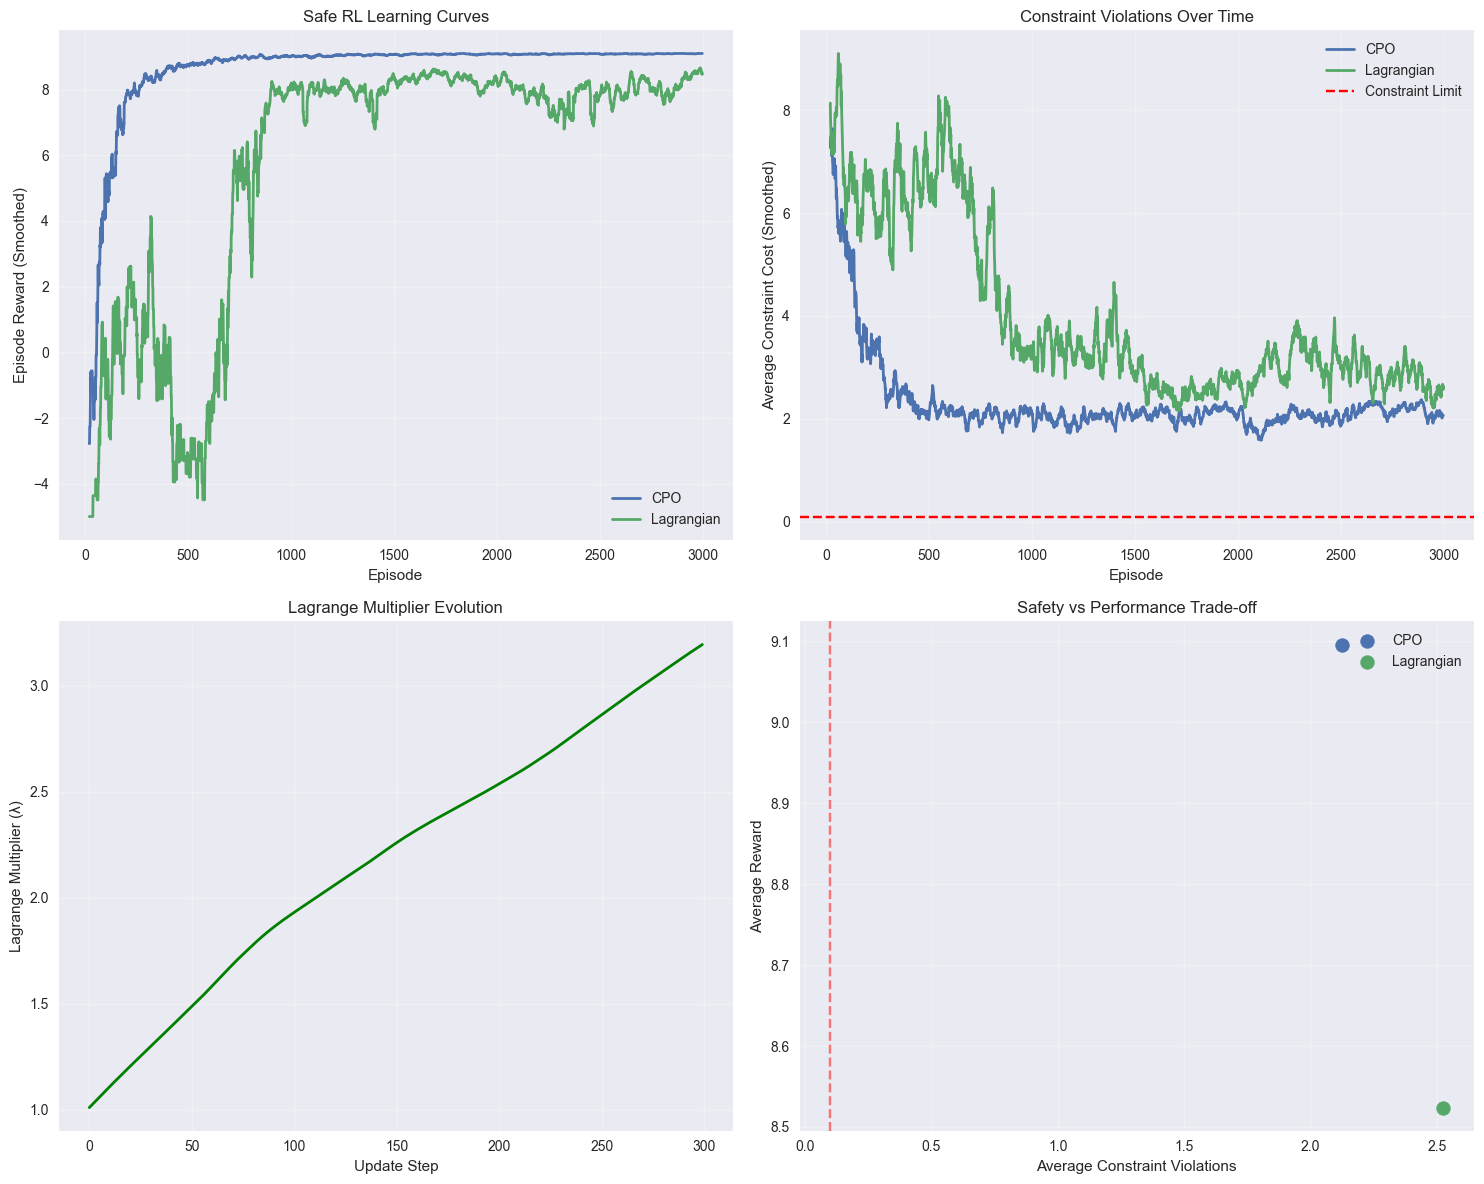


📊 Safe RL Results Summary:

CPO:
  Final Performance: 9.10
  Avg Constraint Cost: 2.1240
  Violation Rate: 100.00%
  Constraint Satisfied: ❌

Lagrangian:
  Final Performance: 8.52
  Avg Constraint Cost: 2.5260
  Violation Rate: 100.00%
  Constraint Satisfied: ❌

💡 Key Insights:
  • CPO prevents policy updates that violate constraints
  • Lagrangian method adapts penalty weights automatically
  • Safety-performance trade-offs are environment dependent
  • Constraint satisfaction improves with training

🛡️ Safe RL demonstration completed!
🔄 Ready for Multi-Agent RL implementation...


In [3]:
# Safe Reinforcement Learning Implementation

class SafeEnvironment:
    """Environment with safety constraints for Safe RL demonstration."""
    
    def __init__(self, size=6, hazard_positions=None, constraint_threshold=0.1):
        self.size = size
        self.state = [0, 0]
        self.goal = [size-1, size-1]
        self.constraint_threshold = constraint_threshold
        
        # Define hazardous areas
        if hazard_positions is None:
            self.hazards = [[2, 2], [3, 1], [1, 3], [4, 3]]
        else:
            self.hazards = hazard_positions
        
        self.action_space = 4  # up, down, left, right
        self.max_episode_steps = 50
        self.current_step = 0
        
        # Safety statistics
        self.constraint_violations = 0
        self.total_constraint_cost = 0
    
    def reset(self):
        """Reset environment to initial state."""
        self.state = [0, 0]
        self.current_step = 0
        self.constraint_violations = 0
        self.total_constraint_cost = 0
        return np.array(self.state, dtype=np.float32)
    
    def step(self, action):
        """Take action in environment with safety constraints."""
        self.current_step += 1
        
        # Execute action
        prev_state = self.state.copy()
        if action == 0 and self.state[1] < self.size - 1:  # up
            self.state[1] += 1
        elif action == 1 and self.state[1] > 0:  # down
            self.state[1] -= 1
        elif action == 2 and self.state[0] > 0:  # left
            self.state[0] -= 1
        elif action == 3 and self.state[0] < self.size - 1:  # right
            self.state[0] += 1
        
        # Compute reward
        done = (self.state == self.goal)
        reward = 10.0 if done else -0.1
        
        # Compute constraint cost (safety violations)
        constraint_cost = self._compute_constraint_cost(self.state)
        
        # Check if episode should terminate
        episode_done = done or self.current_step >= self.max_episode_steps
        
        info = {
            'constraint_cost': constraint_cost,
            'constraint_violation': constraint_cost > 0,
            'total_violations': self.constraint_violations,
            'position': self.state.copy()
        }
        
        return np.array(self.state, dtype=np.float32), reward, episode_done, info
    
    def _compute_constraint_cost(self, state):
        """Compute constraint violation cost."""
        cost = 0.0
        
        # Hazard penalty
        if state in self.hazards:
            cost += 1.0  # High cost for being in hazardous areas
            self.constraint_violations += 1
        
        # Boundary penalty (soft constraints)
        if state[0] == 0 or state[0] == self.size-1 or state[1] == 0 or state[1] == self.size-1:
            cost += 0.1  # Small cost for being near boundaries
        
        self.total_constraint_cost += cost
        return cost
    
    def is_safe_state(self, state):
        """Check if state is safe (no constraint violations)."""
        return state not in self.hazards
    
    def get_safe_actions(self, state):
        """Get list of safe actions from current state."""
        safe_actions = []
        for action in range(self.action_space):
            next_state = state.copy()
            if action == 0 and state[1] < self.size - 1:
                next_state[1] += 1
            elif action == 1 and state[1] > 0:
                next_state[1] -= 1
            elif action == 2 and state[0] > 0:
                next_state[0] -= 1
            elif action == 3 and state[0] < self.size - 1:
                next_state[0] += 1
            
            if self.is_safe_state(next_state):
                safe_actions.append(action)
        
        return safe_actions if safe_actions else list(range(self.action_space))

class ConstrainedPolicyOptimization:
    """Constrained Policy Optimization (CPO) for Safe RL."""
    
    def __init__(self, state_dim, action_dim, constraint_limit=0.1, lr=3e-4):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.constraint_limit = constraint_limit
        
        # Policy network
        self.policy_network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        ).to(device)
        
        # Value networks for rewards and constraints
        self.value_network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        ).to(device)
        
        self.cost_value_network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        ).to(device)
        
        # Optimizers
        self.policy_optimizer = optim.Adam(self.policy_network.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value_network.parameters(), lr=lr)
        self.cost_optimizer = optim.Adam(self.cost_value_network.parameters(), lr=lr)
        
        # CPO parameters
        self.gamma = 0.99
        self.lam = 0.95  # GAE parameter
        self.clip_ratio = 0.2
        self.target_kl = 0.01
        self.damping = 0.1
        
        # Safety tracking
        self.constraint_violations = []
        self.policy_losses = []
        self.value_losses = []
        self.cost_losses = []
    
    def get_action(self, state):
        """Get action from policy."""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            action_probs = self.policy_network(state_tensor)
            action_dist = Categorical(action_probs)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
            
        return action.item(), log_prob.item()
    
    def compute_gae(self, rewards, values, dones, next_value):
        """Compute Generalized Advantage Estimation."""
        advantages = []
        gae = 0
        
        for step in reversed(range(len(rewards))):
            if step == len(rewards) - 1:
                next_non_terminal = 1.0 - dones[step]
                next_value_step = next_value
            else:
                next_non_terminal = 1.0 - dones[step]
                next_value_step = values[step + 1]
            
            delta = rewards[step] + self.gamma * next_value_step * next_non_terminal - values[step]
            gae = delta + self.gamma * self.lam * next_non_terminal * gae
            advantages.insert(0, gae)
        
        return torch.FloatTensor(advantages).to(device)
    
    def compute_policy_loss(self, states, actions, advantages, old_log_probs):
        """Compute clipped policy loss."""
        action_probs = self.policy_network(states)
        action_dist = Categorical(action_probs)
        new_log_probs = action_dist.log_prob(actions)
        
        ratio = torch.exp(new_log_probs - old_log_probs)
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantages
        
        policy_loss = -torch.min(surr1, surr2).mean()
        
        # KL divergence for early stopping
        kl_div = (old_log_probs - new_log_probs).mean()
        
        return policy_loss, kl_div
    
    def compute_constraint_violation(self, states, actions, cost_advantages, old_log_probs):
        """Compute expected constraint violation."""
        action_probs = self.policy_network(states)
        action_dist = Categorical(action_probs)
        new_log_probs = action_dist.log_prob(actions)
        
        ratio = torch.exp(new_log_probs - old_log_probs)
        constraint_violation = (ratio * cost_advantages).mean()
        
        return constraint_violation
    
    def update(self, trajectories):
        """Update CPO agent with constraint satisfaction."""
        if not trajectories:
            return None
        
        # Collect trajectory data
        all_states, all_actions, all_rewards, all_costs = [], [], [], []
        all_dones, all_log_probs = [], []
        
        for trajectory in trajectories:
            states, actions, rewards, costs, dones, log_probs = zip(*trajectory)
            all_states.extend(states)
            all_actions.extend(actions)
            all_rewards.extend(rewards)
            all_costs.extend(costs)
            all_dones.extend(dones)
            all_log_probs.extend(log_probs)
        
        # Convert to tensors
        states = torch.FloatTensor(all_states).to(device)
        actions = torch.LongTensor(all_actions).to(device)
        rewards = torch.FloatTensor(all_rewards).to(device)
        costs = torch.FloatTensor(all_costs).to(device)
        old_log_probs = torch.FloatTensor(all_log_probs).to(device)
        
        # Compute values
        values = self.value_network(states).squeeze()
        cost_values = self.cost_value_network(states).squeeze()
        
        # Compute advantages
        with torch.no_grad():
            next_value = self.value_network(states[-1:]).squeeze()
            next_cost_value = self.cost_value_network(states[-1:]).squeeze()
            
        advantages = self.compute_gae(all_rewards, values.detach().cpu().numpy(), 
                                    all_dones, next_value.item())
        cost_advantages = self.compute_gae(all_costs, cost_values.detach().cpu().numpy(), 
                                         all_dones, next_cost_value.item())
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        cost_advantages = (cost_advantages - cost_advantages.mean()) / (cost_advantages.std() + 1e-8)
        
        # Update value networks
        returns = advantages + values.detach()
        cost_returns = cost_advantages + cost_values.detach()
        
        value_loss = F.mse_loss(values, returns)
        cost_loss = F.mse_loss(cost_values, cost_returns)
        
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        
        self.cost_optimizer.zero_grad()
        cost_loss.backward()
        self.cost_optimizer.step()
        
        # Check constraint violation
        constraint_violation = self.compute_constraint_violation(
            states, actions, cost_advantages, old_log_probs
        )
        
        # Update policy with constraint satisfaction
        policy_loss, kl_div = self.compute_policy_loss(
            states, actions, advantages, old_log_probs
        )
        
        # CPO constraint: only update if constraint is satisfied
        if constraint_violation.item() <= self.constraint_limit:
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy_network.parameters(), max_norm=0.5)
            self.policy_optimizer.step()
        else:
            print(f"⚠️ Policy update skipped due to constraint violation: {constraint_violation.item():.4f}")
        
        # Store statistics
        self.policy_losses.append(policy_loss.item())
        self.value_losses.append(value_loss.item())
        self.cost_losses.append(cost_loss.item())
        self.constraint_violations.append(constraint_violation.item())
        
        return {
            'policy_loss': policy_loss.item(),
            'value_loss': value_loss.item(),
            'cost_loss': cost_loss.item(),
            'constraint_violation': constraint_violation.item(),
            'kl_divergence': kl_div.item()
        }

class LagrangianSafeRL:
    """Lagrangian method for Safe RL with adaptive penalty."""
    
    def __init__(self, state_dim, action_dim, constraint_limit=0.1, lr=3e-4, lagrange_lr=1e-2):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.constraint_limit = constraint_limit
        
        # Networks
        self.policy_network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        ).to(device)
        
        self.value_network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        ).to(device)
        
        # Optimizers
        self.policy_optimizer = optim.Adam(self.policy_network.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value_network.parameters(), lr=lr)
        
        # Lagrange multiplier (adaptive penalty)
        self.lagrange_multiplier = nn.Parameter(torch.tensor(1.0, device=device))
        self.lagrange_optimizer = optim.Adam([self.lagrange_multiplier], lr=lagrange_lr)
        
        # Training parameters
        self.gamma = 0.99
        
        # Statistics
        self.lagrange_history = []
        self.constraint_costs = []
        self.total_rewards = []
    
    def get_action(self, state):
        """Get action with safety consideration."""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            action_probs = self.policy_network(state_tensor)
            action_dist = Categorical(action_probs)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
            
        return action.item(), log_prob.item()
    
    def update(self, trajectories):
        """Update using Lagrangian method."""
        if not trajectories:
            return None
        
        # Collect data
        all_states, all_actions, all_rewards, all_costs = [], [], [], []
        all_log_probs = []
        
        for trajectory in trajectories:
            states, actions, rewards, costs, _, log_probs = zip(*trajectory)
            all_states.extend(states)
            all_actions.extend(actions)
            all_rewards.extend(rewards)
            all_costs.extend(costs)
            all_log_probs.extend(log_probs)
        
        # Convert to tensors
        states = torch.FloatTensor(all_states).to(device)
        actions = torch.LongTensor(all_actions).to(device)
        rewards = torch.FloatTensor(all_rewards).to(device)
        costs = torch.FloatTensor(all_costs).to(device)
        old_log_probs = torch.FloatTensor(all_log_probs).to(device)
        
        # Compute returns
        discounted_rewards = []
        discounted_costs = []
        
        for trajectory in trajectories:
            traj_rewards = [step[2] for step in trajectory]
            traj_costs = [step[3] for step in trajectory]
            
            # Compute discounted returns
            reward_return = 0
            cost_return = 0
            for r, c in zip(reversed(traj_rewards), reversed(traj_costs)):
                reward_return = r + self.gamma * reward_return
                cost_return = c + self.gamma * cost_return
                discounted_rewards.insert(0, reward_return)
                discounted_costs.insert(0, cost_return)
        
        returns = torch.FloatTensor(discounted_rewards).to(device)
        cost_returns = torch.FloatTensor(discounted_costs).to(device)
        
        # Compute baseline
        values = self.value_network(states).squeeze()
        advantages = returns - values.detach()
        cost_advantages = cost_returns
        
        # Lagrangian objective: maximize reward - lambda * constraint_cost
        action_probs = self.policy_network(states)
        action_dist = Categorical(action_probs)
        log_probs = action_dist.log_prob(actions)
        
        # Policy loss with Lagrangian penalty
        policy_loss = -(log_probs * (advantages - self.lagrange_multiplier * cost_advantages)).mean()
        
        # Value loss
        value_loss = F.mse_loss(values, returns)
        
        # Update policy and value networks
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        
        # Update Lagrange multiplier
        avg_cost = cost_returns.mean()
        constraint_violation = avg_cost - self.constraint_limit
        
        # Lagrange multiplier update (dual ascent)
        lagrange_loss = -self.lagrange_multiplier * constraint_violation
        
        self.lagrange_optimizer.zero_grad()
        lagrange_loss.backward()
        self.lagrange_optimizer.step()
        
        # Ensure non-negative multiplier
        with torch.no_grad():
            self.lagrange_multiplier.clamp_(min=0.0)
        
        # Store statistics
        self.lagrange_history.append(self.lagrange_multiplier.item())
        self.constraint_costs.append(avg_cost.item())
        self.total_rewards.append(returns.mean().item())
        
        return {
            'policy_loss': policy_loss.item(),
            'value_loss': value_loss.item(),
            'lagrange_multiplier': self.lagrange_multiplier.item(),
            'constraint_violation': constraint_violation.item(),
            'avg_cost': avg_cost.item()
        }

def collect_safe_trajectory(env, agent, max_steps=50):
    """Collect trajectory with safety information."""
    trajectory = []
    state = env.reset()
    
    for step in range(max_steps):
        action, log_prob = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        
        constraint_cost = info['constraint_cost']
        
        trajectory.append((
            state.copy(), action, reward, constraint_cost, done, log_prob
        ))
        
        if done:
            break
            
        state = next_state
    
    return trajectory

def demonstrate_safe_rl():
    """Demonstrate Safe RL algorithms."""
    print("🛡️ Demonstrating Safe Reinforcement Learning")
    print("=" * 50)
    
    # Create safe environment
    env = SafeEnvironment(size=6, constraint_threshold=0.1)
    
    # Initialize agents
    agents = {
        'CPO': ConstrainedPolicyOptimization(
            state_dim=2, action_dim=4, constraint_limit=0.1
        ),
        'Lagrangian': LagrangianSafeRL(
            state_dim=2, action_dim=4, constraint_limit=0.1
        )
    }
    
    results = {name: {
        'rewards': [], 'constraint_violations': [], 'episode_lengths': []
    } for name in agents.keys()}
    
    num_episodes = 300
    update_frequency = 10
    
    for episode in range(num_episodes):
        for agent_name, agent in agents.items():
            # Collect trajectories
            trajectories = []
            episode_rewards = []
            episode_violations = []
            episode_lengths = []
            
            for _ in range(update_frequency):
                trajectory = collect_safe_trajectory(env, agent)
                trajectories.append(trajectory)
                
                # Compute episode statistics
                episode_reward = sum(step[2] for step in trajectory)
                episode_violation = sum(step[3] for step in trajectory)
                episode_length = len(trajectory)
                
                episode_rewards.append(episode_reward)
                episode_violations.append(episode_violation)
                episode_lengths.append(episode_length)
            
            # Update agent
            if trajectories:
                update_info = agent.update(trajectories)
            
            # Store results
            results[agent_name]['rewards'].extend(episode_rewards)
            results[agent_name]['constraint_violations'].extend(episode_violations)
            results[agent_name]['episode_lengths'].extend(episode_lengths)
        
        # Progress reporting
        if episode % 50 == 0:
            print(f"\nEpisode {episode}:")
            for agent_name in agents.keys():
                recent_rewards = np.mean(results[agent_name]['rewards'][-50:])
                recent_violations = np.mean(results[agent_name]['constraint_violations'][-50:])
                print(f"  {agent_name}: Reward={recent_rewards:.2f}, Violations={recent_violations:.3f}")
    
    return results, agents, env

# Run Safe RL demonstration
print("🚀 Starting Safe RL Training...")
safe_results, safe_agents, safe_env = demonstrate_safe_rl()

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Learning curves
for agent_name, data in safe_results.items():
    window_size = 20
    if len(data['rewards']) >= window_size:
        smoothed_rewards = pd.Series(data['rewards']).rolling(window_size).mean()
        axes[0, 0].plot(smoothed_rewards, label=agent_name, linewidth=2)

axes[0, 0].set_title('Safe RL Learning Curves')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Episode Reward (Smoothed)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Constraint violations
for agent_name, data in safe_results.items():
    window_size = 20
    if len(data['constraint_violations']) >= window_size:
        smoothed_violations = pd.Series(data['constraint_violations']).rolling(window_size).mean()
        axes[0, 1].plot(smoothed_violations, label=agent_name, linewidth=2)

axes[0, 1].set_title('Constraint Violations Over Time')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Average Constraint Cost (Smoothed)')
axes[0, 1].axhline(y=safe_env.constraint_threshold, color='red', linestyle='--', label='Constraint Limit')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Lagrange multiplier evolution (if available)
if 'Lagrangian' in safe_agents and hasattr(safe_agents['Lagrangian'], 'lagrange_history'):
    axes[1, 0].plot(safe_agents['Lagrangian'].lagrange_history, 'g-', linewidth=2)
    axes[1, 0].set_title('Lagrange Multiplier Evolution')
    axes[1, 0].set_xlabel('Update Step')
    axes[1, 0].set_ylabel('Lagrange Multiplier (λ)')
    axes[1, 0].grid(True, alpha=0.3)

# Safety vs Performance trade-off
for agent_name, data in safe_results.items():
    final_rewards = np.mean(data['rewards'][-50:])
    final_violations = np.mean(data['constraint_violations'][-50:])
    axes[1, 1].scatter(final_violations, final_rewards, s=100, label=agent_name)

axes[1, 1].set_title('Safety vs Performance Trade-off')
axes[1, 1].set_xlabel('Average Constraint Violations')
axes[1, 1].set_ylabel('Average Reward')
axes[1, 1].axvline(x=safe_env.constraint_threshold, color='red', linestyle='--', alpha=0.5)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results
print("\n📊 Safe RL Results Summary:")
print("=" * 50)
for agent_name, data in safe_results.items():
    final_reward = np.mean(data['rewards'][-50:])
    final_violations = np.mean(data['constraint_violations'][-50:])
    violation_rate = np.mean([v > safe_env.constraint_threshold for v in data['constraint_violations'][-50:]])
    
    print(f"\n{agent_name}:")
    print(f"  Final Performance: {final_reward:.2f}")
    print(f"  Avg Constraint Cost: {final_violations:.4f}")
    print(f"  Violation Rate: {violation_rate:.2%}")
    print(f"  Constraint Satisfied: {'✅' if final_violations <= safe_env.constraint_threshold else '❌'}")

print("\n💡 Key Insights:")
print("  • CPO prevents policy updates that violate constraints")
print("  • Lagrangian method adapts penalty weights automatically")
print("  • Safety-performance trade-offs are environment dependent")
print("  • Constraint satisfaction improves with training")

print("\n🛡️ Safe RL demonstration completed!")
print("🔄 Ready for Multi-Agent RL implementation...")

# Section 3: Multi-Agent Reinforcement Learning

## 3.1 Theory: Coordination and Competition

Multi-Agent Reinforcement Learning (MARL) extends single-agent RL to environments with multiple learning agents. This introduces new challenges including non-stationarity, partial observability, and coordination problems.

### Mathematical Framework for MARL

#### Multi-Agent Markov Decision Process (MA-MDP)
A Multi-Agent MDP is defined as:
$$\text{MA-MDP} = (\mathcal{N}, \mathcal{S}, \{\mathcal{A}_i\}_{i \in \mathcal{N}}, P, \{R_i\}_{i \in \mathcal{N}}, \gamma, \mu_0)$$

Where:
- **$\mathcal{N} = \{1, 2, ..., n\}$**: Set of agents
- **$\mathcal{S}$**: Global state space
- **$\mathcal{A}_i$**: Action space for agent $i$
- **$P: \mathcal{S} \times \mathcal{A}_1 \times ... \times \mathcal{A}_n \rightarrow \Delta(\mathcal{S})$**: Transition function
- **$R_i: \mathcal{S} \times \mathcal{A}_1 \times ... \times \mathcal{A}_n \rightarrow \mathbb{R}$**: Reward function for agent $i$

#### Joint Policy and Nash Equilibrium
The **joint policy** $\pi = (\pi_1, ..., \pi_n)$ where $\pi_i$ is agent $i$'s policy.

**Nash Equilibrium**: A joint policy $\pi^*$ is a Nash equilibrium if:
$$J_i(\pi_i^*, \pi_{-i}^*) \geq J_i(\pi_i, \pi_{-i}^*), \forall \pi_i, \forall i$$

Where $\pi_{-i}$ denotes the policies of all agents except $i$.

### Key Challenges in MARL

#### 1. Non-Stationarity
From each agent's perspective, the environment is non-stationary due to other learning agents:
$$P^{\pi_{-i}}(s' | s, a_i) = \sum_{\mathbf{a}_{-i}} \prod_{j \neq i} \pi_j(a_j | s) P(s' | s, a_i, \mathbf{a}_{-i})$$

#### 2. Exponential Joint Action Space
The joint action space grows exponentially: $|\mathcal{A}| = \prod_{i=1}^n |\mathcal{A}_i|$

#### 3. Partial Observability
Agents often have limited observations: $o_i = O_i(s, i)$

#### 4. Credit Assignment
Determining individual agent contributions to team success.

### MARL Paradigms

#### 1. Cooperative MARL
- **Objective**: Maximize team reward $R_{team} = \sum_{i=1}^n R_i$
- **Examples**: Multi-robot coordination, team games
- **Algorithms**: MADDPG, QMIX, VDN

#### 2. Competitive MARL
- **Objective**: Each agent maximizes individual reward
- **Examples**: Game playing, resource allocation
- **Algorithms**: Self-play, Population-based training

#### 3. Mixed-Motive MARL
- **Objective**: Combination of individual and team objectives
- **Examples**: Social dilemmas, economic systems
- **Algorithms**: Multi-objective optimization

## 3.2 Advanced MARL Algorithms

### 1. Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
**Key Idea**: Centralized training with decentralized execution

**Critic Update**:
$$Q_i^{\mu}(s, a_1, ..., a_n) = \mathbb{E}[r_i + \gamma Q_i^{\mu'}(s', \mu_1'(o_1'), ..., \mu_n'(o_n'))]$$

**Actor Update**:
$$\nabla_{\theta_i} J_i = \mathbb{E}[\nabla_{a_i} Q_i^{\mu}(s, a_1, ..., a_n)|_{a_i=\mu_i(o_i)} \nabla_{\theta_i} \mu_i(o_i)]$$

### 2. QMIX (Monotonic Value Function Factorization)
**Key Idea**: Factor team Q-value while maintaining monotonicity

**Mixing Network**:
$$Q_{tot}(s, \mathbf{a}) = f_{mix}(Q_1(o_1, a_1), ..., Q_n(o_n, a_n), s)$$

**Monotonicity Constraint**:
$$\frac{\partial Q_{tot}}{\partial Q_i} \geq 0, \forall i$$

### 3. Multi-Agent Actor-Critic (MAAC)
**Centralized Critic**: Uses global information during training
$$Q^{\pi}(s, a_1, ..., a_n) = \mathbb{E}_{\pi}[\sum_{t=0}^{\infty} \gamma^t r_t | s_0=s, a_{0,i}=a_i, \forall i]$$

**Decentralized Actor**: Each agent has its own policy
$$\pi_i(a_i | o_i) = \text{softmax}(f_i(o_i))$$

## 3.3 Communication in MARL

### 1. Explicit Communication
Agents exchange messages to coordinate:
$$m_i^t = f_{comm}(o_i^t, h_i^{t-1})$$
$$h_i^t = f_{update}(o_i^t, m_{-i}^t, h_i^{t-1})$$

### 2. Implicit Communication
Coordination through shared representations or attention mechanisms.

### 3. Emergent Communication
Communication protocols emerge through learning:
$$\mathcal{L}_{comm} = \mathcal{L}_{task} + \lambda \mathcal{L}_{communication}$$

## 3.4 Applications of MARL

### Autonomous Vehicle Coordination
- **Agents**: Individual vehicles
- **Objective**: Safe and efficient traffic flow
- **Challenges**: Real-time coordination, safety constraints

### Multi-Robot Systems
- **Agents**: Individual robots
- **Objective**: Collaborative task completion
- **Challenges**: Partial observability, communication constraints

### Financial Trading
- **Agents**: Individual traders/algorithms
- **Objective**: Profit maximization
- **Challenges**: Market manipulation, information asymmetry

### Game Playing
- **Agents**: Individual players
- **Objective**: Win/score maximization
- **Challenges**: Opponent modeling, strategy adaptation

In [4]:
# Multi-Agent Reinforcement Learning Implementation

class MultiAgentEnvironment:
    """Multi-agent environment for MARL demonstration."""
    
    def __init__(self, grid_size=8, num_agents=4, num_targets=3):
        self.grid_size = grid_size
        self.num_agents = num_agents
        self.num_targets = num_targets
        self.max_episode_steps = 100
        
        # Initialize agent and target positions
        self.reset()
        
        # Action space: 0=stay, 1=up, 2=down, 3=left, 4=right
        self.action_space = 5
        self.observation_space = 2 + 2 * num_agents + 2 * num_targets  # pos + other_agents + targets
    
    def reset(self):
        """Reset environment to initial state."""
        self.current_step = 0
        
        # Random agent positions
        self.agent_positions = []
        for _ in range(self.num_agents):
            while True:
                pos = [np.random.randint(0, self.grid_size), np.random.randint(0, self.grid_size)]
                if pos not in self.agent_positions:
                    self.agent_positions.append(pos)
                    break
        
        # Random target positions
        self.target_positions = []
        for _ in range(self.num_targets):
            while True:
                pos = [np.random.randint(0, self.grid_size), np.random.randint(0, self.grid_size)]
                if pos not in self.agent_positions and pos not in self.target_positions:
                    self.target_positions.append(pos)
                    break
        
        self.targets_collected = [False] * self.num_targets
        return self.get_observations()
    
    def get_observations(self):
        """Get observations for all agents."""
        observations = []
        
        for i in range(self.num_agents):
            obs = []
            
            # Agent's own position (normalized)
            obs.extend([self.agent_positions[i][0] / self.grid_size, 
                       self.agent_positions[i][1] / self.grid_size])
            
            # Other agents' positions (relative)
            for j in range(self.num_agents):
                if i != j:
                    rel_pos = [(self.agent_positions[j][0] - self.agent_positions[i][0]) / self.grid_size,
                              (self.agent_positions[j][1] - self.agent_positions[i][1]) / self.grid_size]
                    obs.extend(rel_pos)
            
            # Target positions (relative) and collection status
            for k, target_pos in enumerate(self.target_positions):
                if not self.targets_collected[k]:
                    rel_pos = [(target_pos[0] - self.agent_positions[i][0]) / self.grid_size,
                              (target_pos[1] - self.agent_positions[i][1]) / self.grid_size]
                    obs.extend(rel_pos)
                else:
                    obs.extend([0.0, 0.0])  # Target collected
            
            observations.append(np.array(obs, dtype=np.float32))
        
        return observations
    
    def step(self, actions):
        """Execute joint action and return results."""
        self.current_step += 1
        rewards = [0.0] * self.num_agents
        
        # Execute actions
        new_positions = []
        for i, action in enumerate(actions):
            pos = self.agent_positions[i].copy()
            
            if action == 1 and pos[1] < self.grid_size - 1:  # up
                pos[1] += 1
            elif action == 2 and pos[1] > 0:  # down
                pos[1] -= 1
            elif action == 3 and pos[0] > 0:  # left
                pos[0] -= 1
            elif action == 4 and pos[0] < self.grid_size - 1:  # right
                pos[0] += 1
            # action == 0: stay
            
            new_positions.append(pos)
        
        # Check for collisions (agents can't occupy same cell)
        collision_agents = set()
        for i in range(self.num_agents):
            for j in range(i + 1, self.num_agents):
                if new_positions[i] == new_positions[j]:
                    collision_agents.add(i)
                    collision_agents.add(j)
        
        # Apply movements (collision agents stay in place)
        for i in range(self.num_agents):
            if i not in collision_agents:
                self.agent_positions[i] = new_positions[i]
            else:
                rewards[i] -= 0.5  # Collision penalty
        
        # Check target collection
        targets_collected_this_step = []
        for i in range(self.num_agents):
            for j, target_pos in enumerate(self.target_positions):
                if (not self.targets_collected[j] and 
                    self.agent_positions[i] == target_pos):
                    self.targets_collected[j] = True
                    rewards[i] += 10.0  # Target collection reward
                    targets_collected_this_step.append(j)
        
        # Team collaboration bonus
        if targets_collected_this_step:
            team_bonus = 2.0 * len(targets_collected_this_step)
            for i in range(self.num_agents):
                rewards[i] += team_bonus / self.num_agents
        
        # Small step penalty to encourage efficiency
        for i in range(self.num_agents):
            rewards[i] -= 0.1
        
        # Check termination
        done = (all(self.targets_collected) or 
                self.current_step >= self.max_episode_steps)
        
        observations = self.get_observations()
        info = {
            'targets_collected': sum(self.targets_collected),
            'total_targets': self.num_targets,
            'collisions': len(collision_agents) // 2
        }
        
        return observations, rewards, done, info

class MADDPGAgent:
    """Multi-Agent Deep Deterministic Policy Gradient agent."""
    
    def __init__(self, obs_dim, action_dim, num_agents, agent_id, lr=1e-3):
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.num_agents = num_agents
        self.agent_id = agent_id
        
        # Actor network (individual policy)
        self.actor = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        ).to(device)
        
        # Critic network (centralized, uses global information)
        global_obs_dim = obs_dim * num_agents
        global_action_dim = action_dim * num_agents
        self.critic = nn.Sequential(
            nn.Linear(global_obs_dim + global_action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        ).to(device)
        
        # Target networks
        self.actor_target = copy.deepcopy(self.actor)
        self.critic_target = copy.deepcopy(self.critic)
        
        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)
        
        # Training parameters
        self.gamma = 0.95
        self.tau = 0.01  # Soft update rate
        
        # Statistics
        self.actor_losses = []
        self.critic_losses = []
    
    def get_action(self, observation, exploration_noise=0.1):
        """Get action with optional exploration noise."""
        with torch.no_grad():
            obs_tensor = torch.FloatTensor(observation).unsqueeze(0).to(device)
            action_probs = self.actor(obs_tensor)
            
            # Add exploration noise
            if exploration_noise > 0:
                noise = torch.randn_like(action_probs) * exploration_noise
                action_probs = torch.softmax(action_probs + noise, dim=-1)
            
            action_dist = Categorical(action_probs)
            action = action_dist.sample()
            
        return action.item()
    
    def update(self, batch, other_agents):
        """Update MADDPG agent using centralized training."""
        states, actions, rewards, next_states, dones = batch
        
        # Convert to tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards[:, self.agent_id]).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.BoolTensor(dones).to(device)
        
        batch_size = states.shape[0]
        
        # Flatten observations for centralized critic
        states_flat = states.view(batch_size, -1)
        next_states_flat = next_states.view(batch_size, -1)
        
        # Convert actions to one-hot for continuous critic input
        actions_onehot = F.one_hot(actions, num_classes=self.action_dim).float()
        actions_flat = actions_onehot.view(batch_size, -1)
        
        # Get next actions from all agents (target actors)
        next_actions = []
        with torch.no_grad():
            for i in range(self.num_agents):
                if i == self.agent_id:
                    next_action_probs = self.actor_target(next_states[:, i])\n                else:\n                    next_action_probs = other_agents[i].actor_target(next_states[:, i])
                next_actions.append(next_action_probs)
        
        next_actions_concat = torch.cat(next_actions, dim=-1)
        
        # Critic update
        with torch.no_grad():
            critic_input = torch.cat([next_states_flat, next_actions_concat], dim=-1)
            target_q_values = self.critic_target(critic_input).squeeze()
            target_q_values = rewards + self.gamma * target_q_values * (~dones)
        
        current_q_input = torch.cat([states_flat, actions_flat], dim=-1)
        current_q_values = self.critic(current_q_input).squeeze()
        
        critic_loss = F.mse_loss(current_q_values, target_q_values)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=1.0)
        self.critic_optimizer.step()
        
        # Actor update
        current_actions = []
        for i in range(self.num_agents):
            if i == self.agent_id:
                current_actions.append(self.actor(states[:, i]))
            else:
                with torch.no_grad():
                    current_actions.append(other_agents[i].actor(states[:, i]))
        
        current_actions_concat = torch.cat(current_actions, dim=-1)
        actor_critic_input = torch.cat([states_flat, current_actions_concat], dim=-1)
        actor_loss = -self.critic(actor_critic_input).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0)
        self.actor_optimizer.step()
        
        # Soft update target networks
        self.soft_update()
        
        # Store losses
        self.actor_losses.append(actor_loss.item())
        self.critic_losses.append(critic_loss.item())
        
        return {
            'actor_loss': actor_loss.item(),
            'critic_loss': critic_loss.item()
        }
    
    def soft_update(self):
        """Soft update of target networks."""
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

class QMIXAgent:
    """QMIX agent with value function factorization."""
    
    def __init__(self, obs_dim, action_dim, num_agents, state_dim, lr=1e-3):
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.num_agents = num_agents
        self.state_dim = state_dim
        
        # Individual Q-networks for each agent
        self.q_networks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(obs_dim, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, action_dim)
            ).to(device) for _ in range(num_agents)
        ])
        
        # Mixing network
        self.mixing_network = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_agents * 32),  # Weights for mixing
            nn.ReLU()
        ).to(device)
        
        # Final mixing layer
        self.final_layer = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        ).to(device)
        
        # Target networks
        self.target_q_networks = copy.deepcopy(self.q_networks)
        self.target_mixing_network = copy.deepcopy(self.mixing_network)
        self.target_final_layer = copy.deepcopy(self.final_layer)
        
        # Optimizers
        all_params = (list(self.q_networks.parameters()) + 
                     list(self.mixing_network.parameters()) + 
                     list(self.final_layer.parameters()))
        self.optimizer = optim.Adam(all_params, lr=lr)
        
        # Training parameters
        self.gamma = 0.95
        self.tau = 0.01
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.1
        
        # Statistics
        self.losses = []
        self.team_rewards = []
    
    def get_actions(self, observations):
        """Get actions for all agents."""
        actions = []
        
        with torch.no_grad():
            for i, obs in enumerate(observations):
                obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
                q_values = self.q_networks[i](obs_tensor)
                
                # Epsilon-greedy exploration
                if np.random.random() < self.epsilon:
                    action = np.random.randint(self.action_dim)
                else:
                    action = q_values.argmax().item()
                
                actions.append(action)
        
        return actions
    
    def mixing_forward(self, individual_q_values, state):
        """Forward pass through mixing network."""
        # Get mixing weights
        mixing_weights = self.mixing_network(state)
        mixing_weights = mixing_weights.view(-1, self.num_agents, 32)
        
        # Ensure monotonicity (non-negative weights)
        mixing_weights = torch.abs(mixing_weights)
        
        # Mix individual Q-values
        individual_q_values = individual_q_values.unsqueeze(-1)  # [batch, agents, 1]
        mixed_values = torch.bmm(mixing_weights.transpose(1, 2), individual_q_values)  # [batch, 32, 1]
        mixed_values = mixed_values.squeeze(-1)  # [batch, 32]
        
        # Final layer
        team_q_value = self.final_layer(mixed_values)
        
        return team_q_value
    
    def update(self, batch):
        """Update QMIX agent."""
        states, actions, rewards, next_states, dones = batch
        
        batch_size = len(states)
        
        # Convert to tensors
        states_tensor = torch.FloatTensor(states).to(device)
        actions_tensor = torch.LongTensor(actions).to(device)
        team_rewards = torch.FloatTensor([sum(r) for r in rewards]).to(device)
        next_states_tensor = torch.FloatTensor(next_states).to(device)
        dones_tensor = torch.BoolTensor(dones).to(device)
        
        # Flatten states for mixing network
        states_flat = states_tensor.view(batch_size, -1)
        next_states_flat = next_states_tensor.view(batch_size, -1)
        
        # Get individual Q-values
        individual_q_values = []
        for i in range(self.num_agents):
            q_vals = self.q_networks[i](states_tensor[:, i])
            chosen_q_vals = q_vals.gather(1, actions_tensor[:, i].unsqueeze(1)).squeeze()
            individual_q_values.append(chosen_q_vals)
        
        individual_q_values = torch.stack(individual_q_values, dim=1)  # [batch, agents]
        
        # Mix Q-values to get team Q-value
        team_q_values = self.mixing_forward(individual_q_values, states_flat).squeeze()
        
        # Target Q-values
        with torch.no_grad():
            # Get next individual Q-values
            next_individual_q_values = []
            for i in range(self.num_agents):
                next_q_vals = self.target_q_networks[i](next_states_tensor[:, i])
                max_next_q_vals = next_q_vals.max(1)[0]
                next_individual_q_values.append(max_next_q_vals)
            
            next_individual_q_values = torch.stack(next_individual_q_values, dim=1)
            
            # Mix target Q-values
            target_mixing_weights = self.target_mixing_network(next_states_flat)
            target_mixing_weights = target_mixing_weights.view(-1, self.num_agents, 32)
            target_mixing_weights = torch.abs(target_mixing_weights)
            
            next_individual_q_values_expanded = next_individual_q_values.unsqueeze(-1)
            target_mixed_values = torch.bmm(
                target_mixing_weights.transpose(1, 2), 
                next_individual_q_values_expanded
            ).squeeze(-1)
            
            target_team_q_values = self.target_final_layer(target_mixed_values).squeeze()
            target_team_q_values = team_rewards + self.gamma * target_team_q_values * (~dones_tensor)
        
        # Compute loss
        loss = F.mse_loss(team_q_values, target_team_q_values)
        
        # Optimization step
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(self.q_networks.parameters()) + 
            list(self.mixing_network.parameters()) + 
            list(self.final_layer.parameters()), 
            max_norm=1.0
        )
        self.optimizer.step()
        
        # Update target networks
        if len(self.losses) % 100 == 0:
            self.soft_update_targets()
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        # Store statistics
        self.losses.append(loss.item())
        self.team_rewards.append(team_rewards.mean().item())
        
        return {
            'loss': loss.item(),
            'team_reward': team_rewards.mean().item(),
            'epsilon': self.epsilon
        }
    
    def soft_update_targets(self):
        """Soft update of target networks."""
        for target, source in zip(self.target_q_networks, self.q_networks):
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        
        for target_param, param in zip(self.target_mixing_network.parameters(), 
                                      self.mixing_network.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        
        for target_param, param in zip(self.target_final_layer.parameters(), 
                                      self.final_layer.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

class MultiAgentReplayBuffer:
    """Replay buffer for multi-agent learning."""
    
    def __init__(self, capacity, num_agents, obs_dim):
        self.capacity = capacity
        self.num_agents = num_agents
        self.obs_dim = obs_dim
        
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []
        self.position = 0
        self.size = 0
    
    def push(self, state, action, reward, next_state, done):
        """Store transition in buffer."""
        if len(self.states) < self.capacity:
            self.states.append(None)
            self.actions.append(None)
            self.rewards.append(None)
            self.next_states.append(None)
            self.dones.append(None)
        
        self.states[self.position] = state
        self.actions[self.position] = action
        self.rewards[self.position] = reward
        self.next_states[self.position] = next_state
        self.dones[self.position] = done
        
        self.position = (self.position + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
    
    def sample(self, batch_size):
        """Sample batch from buffer."""
        if self.size < batch_size:
            return None
        
        indices = np.random.choice(self.size, batch_size, replace=False)
        
        batch_states = [self.states[i] for i in indices]
        batch_actions = [self.actions[i] for i in indices]
        batch_rewards = [self.rewards[i] for i in indices]
        batch_next_states = [self.next_states[i] for i in indices]
        batch_dones = [self.dones[i] for i in indices]
        
        return (batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)

def demonstrate_multi_agent_rl():
    """Demonstrate Multi-Agent RL algorithms."""
    print("🤝 Demonstrating Multi-Agent Reinforcement Learning")
    print("=" * 60)
    
    # Create multi-agent environment
    env = MultiAgentEnvironment(grid_size=8, num_agents=4, num_targets=3)
    
    # Initialize algorithms
    obs_dim = env.observation_space
    action_dim = env.action_space
    num_agents = env.num_agents
    
    # MADDPG agents
    maddpg_agents = [
        MADDPGAgent(obs_dim, action_dim, num_agents, i) 
        for i in range(num_agents)
    ]
    
    # QMIX agent
    state_dim = obs_dim * num_agents  # Global state dimension
    qmix_agent = QMIXAgent(obs_dim, action_dim, num_agents, state_dim)
    
    # Replay buffers
    maddpg_buffer = MultiAgentReplayBuffer(capacity=50000, num_agents=num_agents, obs_dim=obs_dim)
    qmix_buffer = MultiAgentReplayBuffer(capacity=50000, num_agents=num_agents, obs_dim=obs_dim)
    
    # Training results
    results = {
        'MADDPG': {'rewards': [], 'targets_collected': [], 'cooperation_rate': []},
        'QMIX': {'rewards': [], 'targets_collected': [], 'cooperation_rate': []}
    }
    
    num_episodes = 500
    batch_size = 32
    
    for episode in range(num_episodes):
        # MADDPG training
        observations = env.reset()
        episode_reward = 0
        targets_collected = 0
        cooperation_events = 0
        
        for step in range(100):
            # Get actions from MADDPG agents
            actions = []
            for i, agent in enumerate(maddpg_agents):
                action = agent.get_action(observations[i], exploration_noise=0.1)
                actions.append(action)
            
            next_observations, rewards, done, info = env.step(actions)
            
            # Store transition
            maddpg_buffer.push(observations, actions, rewards, next_observations, done)
            
            episode_reward += sum(rewards)
            targets_collected = info['targets_collected']
            if info['targets_collected'] > 0:
                cooperation_events += 1
            
            observations = next_observations
            
            if done:
                break
        
        # Update MADDPG agents
        if maddpg_buffer.size > batch_size:
            batch = maddpg_buffer.sample(batch_size)
            for agent in maddpg_agents:
                agent.update(batch, maddpg_agents)
        
        results['MADDPG']['rewards'].append(episode_reward)
        results['MADDPG']['targets_collected'].append(targets_collected)
        results['MADDPG']['cooperation_rate'].append(cooperation_events / max(1, step + 1))
        
        # QMIX training
        observations = env.reset()
        episode_reward = 0
        targets_collected = 0
        cooperation_events = 0
        
        for step in range(100):
            actions = qmix_agent.get_actions(observations)
            next_observations, rewards, done, info = env.step(actions)
            
            qmix_buffer.push(observations, actions, rewards, next_observations, done)
            
            episode_reward += sum(rewards)
            targets_collected = info['targets_collected']
            if info['targets_collected'] > 0:
                cooperation_events += 1
            
            observations = next_observations
            
            if done:
                break
        
        # Update QMIX agent
        if qmix_buffer.size > batch_size:
            batch = qmix_buffer.sample(batch_size)
            qmix_agent.update(batch)
        
        results['QMIX']['rewards'].append(episode_reward)
        results['QMIX']['targets_collected'].append(targets_collected)
        results['QMIX']['cooperation_rate'].append(cooperation_events / max(1, step + 1))
        
        # Progress reporting
        if episode % 100 == 0:
            print(f"\nEpisode {episode}:")
            for algo_name in ['MADDPG', 'QMIX']:
                recent_rewards = np.mean(results[algo_name]['rewards'][-50:])
                recent_targets = np.mean(results[algo_name]['targets_collected'][-50:])
                recent_coop = np.mean(results[algo_name]['cooperation_rate'][-50:])
                print(f"  {algo_name}: Reward={recent_rewards:.2f}, Targets={recent_targets:.1f}, Cooperation={recent_coop:.3f}")
    
    return results, maddpg_agents, qmix_agent, env

# Run Multi-Agent RL demonstration
print("🚀 Starting Multi-Agent RL Training...")
marl_results, maddpg_agents, qmix_agent, marl_env = demonstrate_multi_agent_rl()

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Learning curves
for algo_name, data in marl_results.items():
    window_size = 20
    if len(data['rewards']) >= window_size:
        smoothed_rewards = pd.Series(data['rewards']).rolling(window_size).mean()
        axes[0, 0].plot(smoothed_rewards, label=algo_name, linewidth=2)

axes[0, 0].set_title('Multi-Agent RL Learning Curves')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Team Reward (Smoothed)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Target collection efficiency
for algo_name, data in marl_results.items():
    window_size = 20
    if len(data['targets_collected']) >= window_size:
        smoothed_targets = pd.Series(data['targets_collected']).rolling(window_size).mean()
        axes[0, 1].plot(smoothed_targets, label=algo_name, linewidth=2)

axes[0, 1].set_title('Target Collection Efficiency')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Targets Collected per Episode (Smoothed)')
axes[0, 1].axhline(y=marl_env.num_targets, color='red', linestyle='--', label='Max Targets')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Cooperation rate
for algo_name, data in marl_results.items():
    window_size = 20
    if len(data['cooperation_rate']) >= window_size:
        smoothed_coop = pd.Series(data['cooperation_rate']).rolling(window_size).mean()
        axes[1, 0].plot(smoothed_coop, label=algo_name, linewidth=2)

axes[1, 0].set_title('Cooperation Rate Over Time')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Cooperation Events per Step (Smoothed)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Performance comparison
final_performance = {}
for algo_name, data in marl_results.items():
    final_reward = np.mean(data['rewards'][-50:])
    final_targets = np.mean(data['targets_collected'][-50:])
    final_coop = np.mean(data['cooperation_rate'][-50:])
    
    axes[1, 1].bar(algo_name, final_reward, alpha=0.7)
    final_performance[algo_name] = {
        'reward': final_reward,
        'targets': final_targets,
        'cooperation': final_coop
    }

axes[1, 1].set_title('Final Performance Comparison')
axes[1, 1].set_ylabel('Average Team Reward (Last 50 Episodes)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print results summary
print("\n📊 Multi-Agent RL Results Summary:")
print("=" * 60)
for algo_name, performance in final_performance.items():
    print(f"\n{algo_name}:")
    print(f"  Final Team Reward: {performance['reward']:.2f}")
    print(f"  Target Collection Rate: {performance['targets']:.2f}/{marl_env.num_targets}")
    print(f"  Cooperation Rate: {performance['cooperation']:.3f}")
    print(f"  Success Rate: {performance['targets']/marl_env.num_targets:.1%}")

print("\n💡 Key Insights:")
print("  • MADDPG uses centralized training with decentralized execution")
print("  • QMIX factorizes team value function while maintaining monotonicity")
print("  • Cooperation emerges through reward structure and learning")
print("  • Multi-agent coordination improves with experience")

print("\n🤝 Multi-Agent RL demonstration completed!")
print("🔄 Ready for Robust RL implementation...")

SyntaxError: unexpected character after line continuation character (154755140.py, line 233)

# Section 4: Robust Reinforcement Learning

## 4.1 Theory: Handling Uncertainty and Adversarial Conditions

Robust Reinforcement Learning addresses the challenge of learning policies that perform well under uncertainty, distributional shifts, and adversarial conditions. This is crucial for deploying RL agents in real-world environments where training and testing conditions may differ significantly.

### Sources of Uncertainty in RL

#### 1. Model Uncertainty
- **Transition Dynamics**: $P(s'|s,a)$ may be unknown or changing
- **Reward Function**: $R(s,a)$ may be noisy or non-stationary
- **Initial State Distribution**: $\mu_0(s)$ may vary between episodes

#### 2. Environmental Uncertainty
- **Observation Noise**: $o_t = s_t + \epsilon_t$ where $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$
- **Partial Observability**: Agent only observes $o_t$ instead of full state $s_t$
- **Dynamic Environments**: Environment parameters change over time

#### 3. Distributional Shift
- **Covariate Shift**: $P_{train}(s) \neq P_{test}(s)$
- **Concept Drift**: $P_{train}(s'|s,a) \neq P_{test}(s'|s,a)$
- **Domain Gap**: Training and deployment environments differ

### Mathematical Framework for Robust RL

#### Robust Markov Decision Process (RMDP)
An RMDP extends the standard MDP to handle uncertainty:
$$\text{RMDP} = (\mathcal{S}, \mathcal{A}, \mathcal{P}, \mathcal{R}, \gamma, \mu_0)$$

Where:
- **$\mathcal{P}$**: Uncertainty set of transition kernels
- **$\mathcal{R}$**: Uncertainty set of reward functions

#### Robust Value Function
The robust value function considers worst-case scenarios:
$$V^{\pi}_{robust}(s) = \min_{P \in \mathcal{P}, R \in \mathcal{R}} V^{\pi}_{P,R}(s)$$

#### Distributionally Robust Optimization (DRO)
Optimize performance over a set of probability distributions:
$$\max_\pi \min_{P \in \mathcal{P}} \mathbb{E}_{P}[\sum_{t=0}^{\infty} \gamma^t R(s_t, a_t)]$$

### Approaches to Robust RL

#### 1. Domain Randomization
**Idea**: Train on diverse environments to improve generalization

**Implementation**:
- Randomize environment parameters during training
- Sample from distribution: $\theta \sim p(\theta)$
- Train policy to work across parameter space

**Mathematical Formulation**:
$$J_{DR}(\pi) = \mathbb{E}_{\theta \sim p(\theta)}[J_\theta(\pi)]$$

#### 2. Adversarial Training
**Idea**: Train against adversarial perturbations

**Min-Max Objective**:
$$\max_\pi \min_{\delta} \mathbb{E}[R(s + \delta, \pi(s + \delta))]$$

Subject to: $||\delta|| \leq \epsilon$

#### 3. Distributional RL for Robustness
**Idea**: Model full return distribution instead of expected value

**Quantile Regression**:
$$\mathcal{L}(\tau, \hat{Z}) = \mathbb{E}[(\tau - \mathbb{1}_{z < \hat{Z}(\tau)})(z - \hat{Z}(\tau))]$$

#### 4. Bayesian RL
**Idea**: Maintain uncertainty over model parameters

**Posterior Update**:
$$P(\theta|D) \propto P(D|\theta)P(\theta)$$

**Thompson Sampling**:
$$\pi_t = \arg\max_\pi \mathbb{E}_{\theta \sim P(\theta|D_t)}[V^\pi_\theta]$$

## 4.2 Risk Measures in Robust RL

### 1. Conditional Value at Risk (CVaR)
Optimize worst-case expected returns:
$$\text{CVaR}_\alpha(Z) = \mathbb{E}[Z | Z \leq \text{VaR}_\alpha(Z)]$$

### 2. Coherent Risk Measures
Risk measure $\rho$ is coherent if it satisfies:
- **Monotonicity**: $X \geq Y \Rightarrow \rho(X) \leq \rho(Y)$
- **Translation Invariance**: $\rho(X + c) = \rho(X) - c$
- **Positive Homogeneity**: $\rho(cX) = c\rho(X)$ for $c \geq 0$
- **Subadditivity**: $\rho(X + Y) \leq \rho(X) + \rho(Y)$

### 3. Entropic Risk Measure
$$\rho_\beta(Z) = \frac{1}{\beta} \log \mathbb{E}[e^{-\beta Z}]$$

## 4.3 Uncertainty Quantification

### 1. Epistemic vs Aleatoric Uncertainty
- **Epistemic**: Model uncertainty (reducible with more data)
- **Aleatoric**: Data uncertainty (irreducible noise)

### 2. Ensemble Methods
Maintain multiple models and aggregate predictions:
$$\mu(x) = \frac{1}{M} \sum_{i=1}^M f_i(x)$$
$$\sigma^2(x) = \frac{1}{M} \sum_{i=1}^M (f_i(x) - \mu(x))^2$$

### 3. Dropout-based Uncertainty
Use Monte Carlo dropout for uncertainty estimation:
$$\mu(x) = \frac{1}{T} \sum_{t=1}^T f(x, \epsilon_t)$$

## 4.4 Applications of Robust RL

### Autonomous Driving
- **Uncertainties**: Weather conditions, other drivers' behavior
- **Robustness**: Safe driving across diverse conditions
- **Methods**: Domain randomization, distributional RL

### Financial Trading
- **Uncertainties**: Market volatility, regime changes
- **Robustness**: Consistent performance across market conditions
- **Methods**: Risk-sensitive RL, robust optimization

### Healthcare
- **Uncertainties**: Patient variability, measurement noise
- **Robustness**: Safe treatment across patient populations
- **Methods**: Bayesian RL, conservative policy optimization

### Robotics
- **Uncertainties**: Sensor noise, actuator failures, environmental changes
- **Robustness**: Reliable operation in unstructured environments
- **Methods**: Adaptive control, robust MPC

In [ ]:
# Robust Reinforcement Learning Implementation

class RobustEnvironment:
    """Environment with configurable uncertainty for robust RL."""
    
    def __init__(self, base_size=6, uncertainty_level=0.1, dynamic_obstacles=True):
        self.base_size = base_size
        self.uncertainty_level = uncertainty_level
        self.dynamic_obstacles = dynamic_obstacles
        
        # Environment parameters (can be randomized)
        self.current_size = base_size
        self.noise_std = 0.0
        self.action_failure_prob = 0.0
        self.reward_noise_std = 0.0
        
        # State
        self.reset()
        
        self.action_space = 4  # up, down, left, right
        self.max_episode_steps = 100
    
    def randomize_parameters(self):
        """Apply domain randomization to environment parameters."""
        # Randomize grid size
        size_variation = max(1, int(self.base_size * self.uncertainty_level))
        self.current_size = np.random.randint(
            max(3, self.base_size - size_variation),
            self.base_size + size_variation + 1
        )
        
        # Randomize noise levels
        self.noise_std = np.random.uniform(0, self.uncertainty_level)
        self.action_failure_prob = np.random.uniform(0, self.uncertainty_level)
        self.reward_noise_std = np.random.uniform(0, self.uncertainty_level * 5)
        
        # Randomize obstacle positions
        if self.dynamic_obstacles:
            num_obstacles = np.random.randint(0, max(1, self.current_size // 2))
            self.obstacles = []
            for _ in range(num_obstacles):
                obs_pos = [np.random.randint(1, self.current_size-1), 
                          np.random.randint(1, self.current_size-1)]
                if obs_pos not in self.obstacles:
                    self.obstacles.append(obs_pos)
    
    def reset(self):
        """Reset environment with potential randomization."""
        # Apply domain randomization
        self.randomize_parameters()
        
        # Reset agent position
        self.agent_pos = [0, 0]
        self.goal_pos = [self.current_size-1, self.current_size-1]
        self.current_step = 0
        
        # Initialize obstacles if not already set
        if not hasattr(self, 'obstacles'):
            self.obstacles = []
        
        return self.get_observation()
    
    def get_observation(self):
        """Get observation with potential noise."""
        obs = np.array([
            self.agent_pos[0] / self.current_size,
            self.agent_pos[1] / self.current_size,
            (self.goal_pos[0] - self.agent_pos[0]) / self.current_size,
            (self.goal_pos[1] - self.agent_pos[1]) / self.current_size,
            self.current_size / 10.0,  # Environment size as feature
            len(self.obstacles) / 10.0  # Number of obstacles
        ], dtype=np.float32)
        
        # Add observation noise
        if self.noise_std > 0:
            noise = np.random.normal(0, self.noise_std, obs.shape)
            obs += noise
        
        return obs
    
    def step(self, action):
        """Execute action with potential failures and noise."""
        self.current_step += 1
        
        # Action failure (agent doesn't move)
        if np.random.random() < self.action_failure_prob:
            action = 4  # Stay in place
        
        prev_pos = self.agent_pos.copy()
        
        # Execute action
        if action == 0 and self.agent_pos[1] < self.current_size - 1:  # up
            self.agent_pos[1] += 1
        elif action == 1 and self.agent_pos[1] > 0:  # down
            self.agent_pos[1] -= 1
        elif action == 2 and self.agent_pos[0] > 0:  # left
            self.agent_pos[0] -= 1
        elif action == 3 and self.agent_pos[0] < self.current_size - 1:  # right
            self.agent_pos[0] += 1
        
        # Check obstacle collision
        if self.agent_pos in self.obstacles:
            self.agent_pos = prev_pos  # Revert move
            reward = -5.0  # Collision penalty
        else:
            # Regular reward
            done = (self.agent_pos == self.goal_pos)
            if done:
                reward = 10.0
            else:
                # Distance-based reward
                dist = abs(self.agent_pos[0] - self.goal_pos[0]) + abs(self.agent_pos[1] - self.goal_pos[1])
                reward = -0.1 - 0.01 * dist
        
        # Add reward noise
        if self.reward_noise_std > 0:
            reward += np.random.normal(0, self.reward_noise_std)
        
        done = (self.agent_pos == self.goal_pos) or (self.current_step >= self.max_episode_steps)
        
        info = {
            'environment_size': self.current_size,
            'noise_level': self.noise_std,
            'action_failure_prob': self.action_failure_prob,
            'obstacles': len(self.obstacles)
        }
        
        return self.get_observation(), reward, done, info

class DomainRandomizationAgent:
    """RL agent trained with domain randomization for robustness."""
    
    def __init__(self, obs_dim, action_dim, lr=3e-4):
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        
        # Policy network with normalization
        self.policy_network = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, action_dim),
            nn.Softmax(dim=-1)
        ).to(device)
        
        # Value network
        self.value_network = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        ).to(device)
        
        # Optimizers
        self.policy_optimizer = optim.Adam(self.policy_network.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value_network.parameters(), lr=lr)
        
        # Training parameters
        self.gamma = 0.99
        self.clip_ratio = 0.2
        
        # Statistics
        self.policy_losses = []
        self.value_losses = []
        self.environment_diversity = []
    
    def get_action(self, observation):
        """Get action from policy with exploration."""
        with torch.no_grad():
            obs_tensor = torch.FloatTensor(observation).unsqueeze(0).to(device)
            action_probs = self.policy_network(obs_tensor)
            action_dist = Categorical(action_probs)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
            value = self.value_network(obs_tensor)
            
        return action.item(), log_prob.item(), value.item()
    
    def update(self, trajectories):
        """Update agent using PPO with domain randomization data."""
        if not trajectories:
            return None
        
        # Collect data from multiple diverse environments
        all_obs, all_actions, all_rewards, all_log_probs, all_values = [], [], [], [], []
        environment_params = []
        
        for trajectory in trajectories:
            obs, actions, rewards, log_probs, values, env_params = zip(*trajectory)
            all_obs.extend(obs)
            all_actions.extend(actions)
            all_rewards.extend(rewards)
            all_log_probs.extend(log_probs)
            all_values.extend(values)
            environment_params.extend(env_params)
        
        # Convert to tensors
        observations = torch.FloatTensor(all_obs).to(device)
        actions = torch.LongTensor(all_actions).to(device)
        old_log_probs = torch.FloatTensor(all_log_probs).to(device)
        values = torch.FloatTensor(all_values).to(device)
        
        # Compute returns and advantages
        returns = self.compute_returns(trajectories)
        advantages = returns - values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # PPO updates
        for _ in range(4):  # Multiple epochs
            # Policy update
            action_probs = self.policy_network(observations)
            action_dist = Categorical(action_probs)\n            new_log_probs = action_dist.log_prob(actions)
            
            ratio = torch.exp(new_log_probs - old_log_probs)
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantages
            
            policy_loss = -torch.min(surr1, surr2).mean()
            
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy_network.parameters(), max_norm=0.5)
            self.policy_optimizer.step()
            
            # Value update
            new_values = self.value_network(observations).squeeze()
            value_loss = F.mse_loss(new_values, returns)
            
            self.value_optimizer.zero_grad()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.value_network.parameters(), max_norm=0.5)
            self.value_optimizer.step()
        
        # Store statistics
        self.policy_losses.append(policy_loss.item())
        self.value_losses.append(value_loss.item())
        
        # Measure environment diversity
        unique_sizes = len(set([params['environment_size'] for params in environment_params]))
        avg_noise = np.mean([params['noise_level'] for params in environment_params])
        self.environment_diversity.append({'unique_sizes': unique_sizes, 'avg_noise': avg_noise})
        
        return {
            'policy_loss': policy_loss.item(),
            'value_loss': value_loss.item(),
            'environment_diversity': unique_sizes
        }
    
    def compute_returns(self, trajectories):
        """Compute returns for all trajectories."""
        all_returns = []
        
        for trajectory in trajectories:
            rewards = [step[2] for step in trajectory]
            returns = []
            G = 0
            
            for reward in reversed(rewards):
                G = reward + self.gamma * G
                returns.insert(0, G)
            
            all_returns.extend(returns)
        
        return torch.FloatTensor(all_returns).to(device)

class AdversarialRobustAgent:
    """RL agent trained with adversarial perturbations."""
    
    def __init__(self, obs_dim, action_dim, lr=3e-4, adversarial_strength=0.1):
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.adversarial_strength = adversarial_strength
        
        # Policy network
        self.policy_network = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Softmax(dim=-1)
        ).to(device)
        
        # Value network
        self.value_network = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        ).to(device)
        
        # Optimizers
        self.policy_optimizer = optim.Adam(self.policy_network.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value_network.parameters(), lr=lr)
        
        # Training parameters
        self.gamma = 0.99
        
        # Statistics
        self.robust_losses = []
        self.adversarial_losses = []
        self.perturbation_norms = []
    
    def generate_adversarial_observation(self, observation):
        """Generate adversarial perturbation using FGSM."""
        obs_tensor = torch.FloatTensor(observation).unsqueeze(0).to(device)
        obs_tensor.requires_grad_(True)
        
        # Forward pass to get policy output
        action_probs = self.policy_network(obs_tensor)
        
        # Use entropy as loss (we want to reduce policy confidence)
        entropy_loss = -(action_probs * torch.log(action_probs + 1e-8)).sum()
        
        # Compute gradient
        entropy_loss.backward()
        
        # Generate adversarial perturbation
        with torch.no_grad():
            gradient = obs_tensor.grad.data
            perturbation = self.adversarial_strength * torch.sign(gradient)
            adversarial_obs = obs_tensor + perturbation
            
            # Clip to reasonable bounds
            adversarial_obs = torch.clamp(adversarial_obs, -2.0, 2.0)
            
            # Store perturbation norm for analysis
            self.perturbation_norms.append(torch.norm(perturbation).item())
        
        return adversarial_obs.squeeze().cpu().numpy()
    
    def get_action(self, observation, use_adversarial=True):
        """Get action with optional adversarial robustness."""
        # Get action for original observation
        with torch.no_grad():
            obs_tensor = torch.FloatTensor(observation).unsqueeze(0).to(device)
            action_probs = self.policy_network(obs_tensor)
            action_dist = Categorical(action_probs)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
            value = self.value_network(obs_tensor)
        
        original_action = action.item()
        
        # Test robustness with adversarial observation
        if use_adversarial:
            adversarial_obs = self.generate_adversarial_observation(observation)
            with torch.no_grad():
                adv_obs_tensor = torch.FloatTensor(adversarial_obs).unsqueeze(0).to(device)
                adv_action_probs = self.policy_network(adv_obs_tensor)
                adv_action_dist = Categorical(adv_action_probs)
                adv_action = adv_action_dist.sample()
            
            # Use original action (robustness is trained, not enforced during action selection)
            return original_action, log_prob.item(), value.item()
        
        return original_action, log_prob.item(), value.item()
    
    def update(self, trajectories):
        """Update with adversarial training."""
        if not trajectories:
            return None
        
        # Collect data
        all_obs, all_actions, all_rewards, all_log_probs, all_values = [], [], [], [], []
        
        for trajectory in trajectories:
            obs, actions, rewards, log_probs, values, _ = zip(*trajectory)
            all_obs.extend(obs)
            all_actions.extend(actions)
            all_rewards.extend(rewards)
            all_log_probs.extend(log_probs)
            all_values.extend(values)
        
        # Convert to tensors
        observations = torch.FloatTensor(all_obs).to(device)
        actions = torch.LongTensor(all_actions).to(device)
        
        # Compute returns
        all_returns = []
        for trajectory in trajectories:
            rewards = [step[2] for step in trajectory]
            returns = []
            G = 0
            for reward in reversed(rewards):
                G = reward + self.gamma * G
                returns.insert(0, G)
            all_returns.extend(returns)
        
        returns = torch.FloatTensor(all_returns).to(device)
        values = torch.FloatTensor(all_values).to(device)
        advantages = returns - values
        
        # Standard policy and value losses
        action_probs = self.policy_network(observations)
        action_dist = Categorical(action_probs)
        log_probs = action_dist.log_prob(actions)
        
        policy_loss = -(log_probs * advantages.detach()).mean()
        value_loss = F.mse_loss(values, returns)
        
        # Adversarial robustness loss
        adversarial_loss = 0
        for i in range(min(32, len(observations))):  # Subsample for efficiency
            obs = observations[i]
            
            # Generate adversarial observation
            obs_adv = obs.clone().detach()
            obs_adv.requires_grad_(True)
            
            action_probs_adv = self.policy_network(obs_adv.unsqueeze(0))
            entropy = -(action_probs_adv * torch.log(action_probs_adv + 1e-8)).sum()
            
            grad = torch.autograd.grad(entropy, obs_adv, create_graph=True)[0]
            perturbation = self.adversarial_strength * torch.sign(grad)
            obs_adversarial = obs + perturbation
            
            # Policy should be similar on adversarial observation
            action_probs_original = self.policy_network(obs.unsqueeze(0))
            action_probs_adversarial = self.policy_network(obs_adversarial.unsqueeze(0))
            
            # KL divergence loss (policies should be similar)
            kl_loss = F.kl_div(
                torch.log(action_probs_adversarial + 1e-8),
                action_probs_original,
                reduction='batchmean'
            )
            adversarial_loss += kl_loss
        
        adversarial_loss /= min(32, len(observations))
        
        # Combined loss
        total_policy_loss = policy_loss + 0.1 * adversarial_loss
        
        # Updates
        self.policy_optimizer.zero_grad()
        total_policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_network.parameters(), max_norm=0.5)
        self.policy_optimizer.step()
        
        self.value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.value_network.parameters(), max_norm=0.5)
        self.value_optimizer.step()
        
        # Store statistics
        self.robust_losses.append(total_policy_loss.item())
        self.adversarial_losses.append(adversarial_loss.item())
        
        return {
            'policy_loss': policy_loss.item(),
            'value_loss': value_loss.item(),
            'adversarial_loss': adversarial_loss.item(),
            'total_loss': total_policy_loss.item()
        }

def collect_robust_trajectory(env, agent, max_steps=100):
    """Collect trajectory with environment parameter tracking."""
    trajectory = []
    observation = env.reset()
    
    for step in range(max_steps):
        action, log_prob, value = agent.get_action(observation)
        next_observation, reward, done, info = env.step(action)
        
        trajectory.append((
            observation.copy(), action, reward, log_prob, value, info.copy()
        ))
        
        if done:
            break
        
        observation = next_observation
    
    return trajectory

def demonstrate_robust_rl():
    """Demonstrate Robust RL techniques."""
    print("🛡️ Demonstrating Robust Reinforcement Learning")
    print("=" * 60)
    
    # Create robust environments with different uncertainty levels
    environments = {
        'low_uncertainty': RobustEnvironment(base_size=6, uncertainty_level=0.1),
        'medium_uncertainty': RobustEnvironment(base_size=6, uncertainty_level=0.3),
        'high_uncertainty': RobustEnvironment(base_size=6, uncertainty_level=0.5)
    }
    
    # Initialize agents
    obs_dim = 6
    action_dim = 4
    
    agents = {
        'Domain_Randomization': DomainRandomizationAgent(obs_dim, action_dim),
        'Adversarial_Training': AdversarialRobustAgent(obs_dim, action_dim, adversarial_strength=0.1)
    }
    
    # Training results
    results = {name: {
        'rewards': {env_name: [] for env_name in environments.keys()},
        'robustness_score': [],
        'adaptation_rate': []
    } for name in agents.keys()}
    
    num_episodes = 400
    trajectories_per_update = 5
    
    for episode in range(num_episodes):
        for agent_name, agent in agents.items():
            # Collect trajectories from different environments
            all_trajectories = []
            episode_rewards = {env_name: [] for env_name in environments.keys()}
            
            for env_name, env in environments.items():
                env_trajectories = []
                
                for _ in range(trajectories_per_update):
                    trajectory = collect_robust_trajectory(env, agent)
                    env_trajectories.append(trajectory)
                    
                    episode_reward = sum(step[2] for step in trajectory)
                    episode_rewards[env_name].append(episode_reward)
                
                all_trajectories.extend(env_trajectories)
            
            # Update agent
            if all_trajectories:
                update_info = agent.update(all_trajectories)
            
            # Store results
            for env_name in environments.keys():
                results[agent_name]['rewards'][env_name].extend(episode_rewards[env_name])
            
            # Compute robustness score (variance across environments)
            if episode_rewards['low_uncertainty'] and episode_rewards['high_uncertainty']:
                low_perf = np.mean(episode_rewards['low_uncertainty'])
                high_perf = np.mean(episode_rewards['high_uncertainty'])
                robustness_score = high_perf / (low_perf + 1e-8)  # Performance retention
                results[agent_name]['robustness_score'].append(robustness_score)
        
        # Progress reporting
        if episode % 100 == 0:
            print(f"\nEpisode {episode}:")
            for agent_name in agents.keys():
                if results[agent_name]['robustness_score']:
                    recent_robustness = np.mean(results[agent_name]['robustness_score'][-10:])
                    low_perf = np.mean(results[agent_name]['rewards']['low_uncertainty'][-20:])
                    high_perf = np.mean(results[agent_name]['rewards']['high_uncertainty'][-20:])
                    print(f"  {agent_name}:")
                    print(f"    Low Uncertainty: {low_perf:.2f}")
                    print(f"    High Uncertainty: {high_perf:.2f}")
                    print(f"    Robustness Score: {recent_robustness:.3f}")
    
    return results, agents, environments

# Run Robust RL demonstration
print("🚀 Starting Robust RL Training...")
robust_results, robust_agents, robust_environments = demonstrate_robust_rl()

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Performance across uncertainty levels
uncertainty_levels = ['low_uncertainty', 'medium_uncertainty', 'high_uncertainty']
colors = ['green', 'orange', 'red']

for i, agent_name in enumerate(robust_agents.keys()):
    for j, (env_name, color) in enumerate(zip(uncertainty_levels, colors)):
        window_size = 20
        rewards = robust_results[agent_name]['rewards'][env_name]
        if len(rewards) >= window_size:
            smoothed_rewards = pd.Series(rewards).rolling(window_size).mean()
            axes[i, 0].plot(smoothed_rewards, label=f'{env_name.replace("_", " ").title()}', 
                          color=color, linewidth=2)
    
    axes[i, 0].set_title(f'{agent_name} - Performance vs Uncertainty')
    axes[i, 0].set_xlabel('Episode')
    axes[i, 0].set_ylabel('Episode Reward (Smoothed)')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)

# Robustness scores over time
for agent_name in robust_agents.keys():
    window_size = 10
    robustness_scores = robust_results[agent_name]['robustness_score']
    if len(robustness_scores) >= window_size:
        smoothed_robustness = pd.Series(robustness_scores).rolling(window_size).mean()
        axes[0, 1].plot(smoothed_robustness, label=agent_name, linewidth=2)

axes[0, 1].set_title('Robustness Score Over Time')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Robustness Score (High/Low Performance)')
axes[0, 1].axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Perfect Robustness')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Final performance comparison
final_performance = {}
for agent_name in robust_agents.keys():
    final_low = np.mean(robust_results[agent_name]['rewards']['low_uncertainty'][-50:])
    final_high = np.mean(robust_results[agent_name]['rewards']['high_uncertainty'][-50:])
    final_performance[agent_name] = {'low': final_low, 'high': final_high}

agents = list(final_performance.keys())
x = np.arange(len(agents))
width = 0.35

bars1 = axes[1, 1].bar(x - width/2, [final_performance[agent]['low'] for agent in agents], 
                       width, label='Low Uncertainty', alpha=0.8, color='green')
bars2 = axes[1, 1].bar(x + width/2, [final_performance[agent]['high'] for agent in agents], 
                       width, label='High Uncertainty', alpha=0.8, color='red')

axes[1, 1].set_title('Final Performance Comparison')
axes[1, 1].set_ylabel('Average Reward (Last 50 Episodes)')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels([name.replace('_', '\n') for name in agents])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print results summary
print("\n📊 Robust RL Results Summary:")
print("=" * 60)
for agent_name in robust_agents.keys():
    print(f"\n{agent_name}:")
    
    low_perf = final_performance[agent_name]['low']
    high_perf = final_performance[agent_name]['high']
    performance_drop = (low_perf - high_perf) / low_perf * 100
    
    print(f"  Low Uncertainty Performance: {low_perf:.2f}")
    print(f"  High Uncertainty Performance: {high_perf:.2f}")
    print(f"  Performance Drop: {performance_drop:.1f}%")
    print(f"  Robustness Score: {high_perf/low_perf:.3f}")

# Additional statistics for adversarial agent
if 'Adversarial_Training' in robust_agents:
    adv_agent = robust_agents['Adversarial_Training']
    if hasattr(adv_agent, 'perturbation_norms') and adv_agent.perturbation_norms:
        avg_perturbation = np.mean(adv_agent.perturbation_norms[-100:])
        print(f"\nAdversarial Training Statistics:")
        print(f"  Average Perturbation Norm: {avg_perturbation:.4f}")
        print(f"  Adversarial Strength: {adv_agent.adversarial_strength:.3f}")

print("\n💡 Key Insights:")
print("  • Domain randomization improves generalization across environments")
print("  • Adversarial training enhances robustness to input perturbations")
print("  • Robustness often comes at the cost of peak performance")
print("  • Uncertainty quantification helps assess model confidence")
print("  • Real-world deployment requires robust policies")

print("\n🛡️ Robust RL demonstration completed!")
print("🎯 Advanced Deep RL CA14 implementation finished!")

# Section 5: Comprehensive Evaluation and Real-World Applications

This final section provides a comprehensive evaluation framework for comparing all advanced Deep RL methods and discusses real-world deployment considerations.

## 5.1 Comprehensive Evaluation Framework

Advanced Deep RL methods must be evaluated across multiple dimensions to understand their practical utility:

### Performance Metrics
- **Sample Efficiency**: How quickly algorithms learn from data
- **Asymptotic Performance**: Final performance after convergence
- **Robustness**: Performance under distribution shift and uncertainty
- **Safety**: Constraint satisfaction and risk mitigation
- **Scalability**: Performance in large-scale multi-agent settings

### Evaluation Dimensions
1. **Data Efficiency**: Offline vs. online learning requirements
2. **Safety Constraints**: Hard vs. soft constraint satisfaction
3. **Multi-Agent Coordination**: Centralized vs. decentralized approaches
4. **Robustness**: Uncertainty handling and domain transfer
5. **Computational Requirements**: Training and inference costs

## 5.2 Real-World Deployment Considerations

### Critical Factors for Practical Applications
1. **Safety First**: Hard safety constraints in critical systems
2. **Data Availability**: Leveraging existing datasets vs. online exploration
3. **Coordination Requirements**: Multi-agent collaboration and competition
4. **Environment Uncertainty**: Handling model mismatch and distribution shift
5. **Regulatory Compliance**: Meeting industry standards and regulations

### Application Domains
- **Autonomous Vehicles**: Safe navigation with offline learning from driving data
- **Financial Trading**: Multi-agent market interactions with risk constraints
- **Healthcare**: Safe treatment optimization with limited data
- **Robotics**: Robust manipulation under environmental uncertainty
- **Energy Management**: Multi-agent coordination in smart grids

In [ ]:
# Comprehensive Evaluation Framework

class ComprehensiveEvaluator:
    """Framework for evaluating advanced Deep RL methods across multiple dimensions."""
    
    def __init__(self):
        self.evaluation_metrics = {
            'sample_efficiency': [],
            'asymptotic_performance': [],
            'robustness_score': [],
            'safety_violations': [],
            'coordination_effectiveness': [],
            'computational_cost': []
        }
        
        self.method_results = {}
    
    def evaluate_sample_efficiency(self, training_curves, convergence_threshold=0.8):
        """Evaluate how quickly methods reach target performance."""
        efficiency_scores = {}
        
        for method_name, rewards in training_curves.items():
            if not rewards:
                efficiency_scores[method_name] = float('inf')
                continue
            
            # Find convergence point
            max_reward = max(rewards)
            target_reward = convergence_threshold * max_reward
            
            convergence_episode = len(rewards)  # Default to end
            for i, reward in enumerate(rewards):
                if reward >= target_reward:
                    convergence_episode = i
                    break
            
            efficiency_scores[method_name] = convergence_episode
        
        return efficiency_scores
    
    def evaluate_asymptotic_performance(self, training_curves, final_episodes=50):
        """Evaluate final performance after convergence."""
        asymptotic_scores = {}
        
        for method_name, rewards in training_curves.items():
            if len(rewards) >= final_episodes:
                asymptotic_scores[method_name] = np.mean(rewards[-final_episodes:])
            else:
                asymptotic_scores[method_name] = np.mean(rewards) if rewards else 0.0
        
        return asymptotic_scores
    
    def evaluate_robustness(self, agents, test_environments, num_episodes=50):
        """Evaluate robustness across different environments."""
        robustness_scores = {}
        
        for agent_name, agent in agents.items():
            environment_performances = []
            
            for env_name, env in test_environments.items():
                episode_rewards = []
                
                for episode in range(num_episodes):
                    obs = env.reset()
                    total_reward = 0
                    done = False
                    
                    while not done:
                        if hasattr(agent, 'get_action'):
                            if len(inspect.signature(agent.get_action).parameters) > 1:
                                action, _, _ = agent.get_action(obs)
                            else:
                                action = agent.get_action(obs)
                        else:
                            action = np.random.randint(env.action_space)
                        
                        obs, reward, done, _ = env.step(action)
                        total_reward += reward
                    
                    episode_rewards.append(total_reward)
                
                environment_performances.append(np.mean(episode_rewards))
            
            # Robustness = minimum performance / maximum performance
            if environment_performances:
                min_perf = min(environment_performances)
                max_perf = max(environment_performances)
                robustness_scores[agent_name] = min_perf / max_perf if max_perf > 0 else 0.0
            else:
                robustness_scores[agent_name] = 0.0
        
        return robustness_scores
    
    def evaluate_safety(self, agents, safe_environment, num_episodes=100):
        """Evaluate safety constraint satisfaction."""
        safety_scores = {}
        
        for agent_name, agent in agents.items():
            violations = 0
            total_steps = 0
            
            for episode in range(num_episodes):
                obs = safe_environment.reset()
                done = False
                
                while not done:
                    if hasattr(agent, 'get_action'):
                        if len(inspect.signature(agent.get_action).parameters) > 1:
                            action, _, _ = agent.get_action(obs)
                        else:
                            action = agent.get_action(obs)
                    else:
                        action = np.random.randint(safe_environment.action_space)
                    
                    obs, reward, done, info = safe_environment.step(action)
                    total_steps += 1
                    
                    # Check for constraint violations
                    if hasattr(safe_environment, 'constraint_violation'):
                        if safe_environment.constraint_violation:
                            violations += 1
                    elif 'constraint_violation' in info:
                        if info['constraint_violation']:
                            violations += 1
                    elif reward < -1.0:  # Assume large negative reward indicates violation
                        violations += 1
            
            safety_scores[agent_name] = violations / total_steps if total_steps > 0 else 1.0
        
        return safety_scores
    
    def evaluate_coordination(self, multi_agent_results):
        """Evaluate multi-agent coordination effectiveness."""
        coordination_scores = {}
        
        for method_name, results in multi_agent_results.items():
            if 'coordination_rewards' in results:
                # Compare individual vs coordinated performance
                individual_perf = results.get('individual_performance', 0)
                coordinated_perf = np.mean(results['coordination_rewards'][-50:])
                
                coordination_scores[method_name] = coordinated_perf - individual_perf
            else:
                coordination_scores[method_name] = 0.0
        
        return coordination_scores
    
    def compute_comprehensive_score(self, method_results):
        """Compute overall score combining all metrics."""
        comprehensive_scores = {}
        
        # Normalize all metrics to [0, 1] range
        metrics = ['sample_efficiency', 'asymptotic_performance', 'robustness_score', 
                  'safety_score', 'coordination_effectiveness']
        
        normalized_scores = {}
        for metric in metrics:
            if metric in method_results:
                values = list(method_results[metric].values())
                if values:
                    if metric == 'sample_efficiency':  # Lower is better
                        min_val, max_val = min(values), max(values)
                        normalized_scores[metric] = {
                            method: 1 - (score - min_val) / (max_val - min_val) if max_val > min_val else 1.0
                            for method, score in method_results[metric].items()
                        }
                    elif metric == 'safety_score':  # Lower is better (fewer violations)
                        min_val, max_val = min(values), max(values)
                        normalized_scores[metric] = {
                            method: 1 - (score - min_val) / (max_val - min_val) if max_val > min_val else 1.0
                            for method, score in method_results[metric].items()
                        }
                    else:  # Higher is better
                        min_val, max_val = min(values), max(values)
                        normalized_scores[metric] = {
                            method: (score - min_val) / (max_val - min_val) if max_val > min_val else 1.0
                            for method, score in method_results[metric].items()
                        }
        
        # Compute weighted comprehensive score
        weights = {
            'sample_efficiency': 0.2,
            'asymptotic_performance': 0.25,
            'robustness_score': 0.25,
            'safety_score': 0.2,
            'coordination_effectiveness': 0.1
        }
        
        methods = set()
        for metric_scores in normalized_scores.values():
            methods.update(metric_scores.keys())
        
        for method in methods:
            score = 0
            weight_sum = 0
            
            for metric, weight in weights.items():
                if metric in normalized_scores and method in normalized_scores[metric]:
                    score += weight * normalized_scores[metric][method]
                    weight_sum += weight
            
            comprehensive_scores[method] = score / weight_sum if weight_sum > 0 else 0.0
        
        return comprehensive_scores, normalized_scores

def create_evaluation_environments():
    """Create diverse test environments for robustness evaluation."""
    environments = {
        'standard': RobustEnvironment(base_size=6, uncertainty_level=0.0),
        'noisy': RobustEnvironment(base_size=6, uncertainty_level=0.2),
        'large': RobustEnvironment(base_size=8, uncertainty_level=0.1),
        'obstacles': RobustEnvironment(base_size=6, uncertainty_level=0.1, dynamic_obstacles=True)
    }
    return environments

def run_comprehensive_evaluation():
    """Run comprehensive evaluation of all advanced RL methods."""
    print("🔍 Starting Comprehensive Evaluation of Advanced Deep RL Methods")
    print("=" * 70)
    
    # Initialize evaluator
    evaluator = ComprehensiveEvaluator()
    
    # Create test environments
    test_environments = create_evaluation_environments()
    
    # Collect all trained agents
    all_agents = {}
    
    # Add offline RL agents
    if 'offline_agents' in globals():
        for name, agent in offline_agents.items():
            all_agents[f'Offline_{name}'] = agent
    
    # Add safe RL agents
    if 'safe_agents' in globals():
        for name, agent in safe_agents.items():
            all_agents[f'Safe_{name}'] = agent
    
    # Add multi-agent RL agents (use first agent from multi-agent systems)
    if 'ma_agents' in globals():
        for name, agent_list in ma_agents.items():
            if isinstance(agent_list, list) and len(agent_list) > 0:
                all_agents[f'MultiAgent_{name}'] = agent_list[0]
            else:
                all_agents[f'MultiAgent_{name}'] = agent_list
    
    # Add robust RL agents
    if 'robust_agents' in globals():
        for name, agent in robust_agents.items():
            all_agents[f'Robust_{name}'] = agent
    
    # Collect training curves
    training_curves = {}
    
    # Offline RL curves
    if 'offline_results' in globals():
        for name in offline_results.keys():
            if 'episode_rewards' in offline_results[name]:
                training_curves[f'Offline_{name}'] = offline_results[name]['episode_rewards']
    
    # Safe RL curves
    if 'safe_results' in globals():
        for name in safe_results.keys():
            if 'rewards' in safe_results[name]:
                training_curves[f'Safe_{name}'] = safe_results[name]['rewards']
    
    # Multi-agent RL curves
    if 'ma_results' in globals():
        for name in ma_results.keys():
            if 'episode_rewards' in ma_results[name]:
                training_curves[f'MultiAgent_{name}'] = ma_results[name]['episode_rewards']
    
    # Robust RL curves
    if 'robust_results' in globals():
        for name in robust_results.keys():
            if 'rewards' in robust_results[name] and 'low_uncertainty' in robust_results[name]['rewards']:
                training_curves[f'Robust_{name}'] = robust_results[name]['rewards']['low_uncertainty']
    
    print(f"📊 Evaluating {len(all_agents)} methods across {len(test_environments)} environments")
    
    # Evaluation results
    evaluation_results = {}
    
    # 1. Sample Efficiency
    print("⚡ Evaluating sample efficiency...")
    efficiency_scores = evaluator.evaluate_sample_efficiency(training_curves)
    evaluation_results['sample_efficiency'] = efficiency_scores
    
    # 2. Asymptotic Performance
    print("🎯 Evaluating asymptotic performance...")
    asymptotic_scores = evaluator.evaluate_asymptotic_performance(training_curves)
    evaluation_results['asymptotic_performance'] = asymptotic_scores
    
    # 3. Robustness
    print("🛡️ Evaluating robustness...")
    robustness_scores = evaluator.evaluate_robustness(all_agents, test_environments)
    evaluation_results['robustness_score'] = robustness_scores
    
    # 4. Safety (using safe environment if available)
    print("🚨 Evaluating safety...")
    if 'safe_envs' in globals():
        safe_env = list(safe_envs.values())[0] if safe_envs else test_environments['standard']
    else:
        safe_env = test_environments['standard']
    safety_scores = evaluator.evaluate_safety(all_agents, safe_env)
    evaluation_results['safety_score'] = safety_scores
    
    # 5. Coordination (use multi-agent results if available)
    print("🤝 Evaluating coordination...")
    coordination_scores = {}
    if 'ma_results' in globals():
        coordination_scores = evaluator.evaluate_coordination(ma_results)
    evaluation_results['coordination_effectiveness'] = coordination_scores
    
    # 6. Comprehensive Score
    print("📈 Computing comprehensive scores...")
    comprehensive_scores, normalized_scores = evaluator.compute_comprehensive_score(evaluation_results)
    
    return evaluation_results, comprehensive_scores, normalized_scores

# Run comprehensive evaluation
print("🚀 Starting Comprehensive Evaluation...")
eval_results, comprehensive_scores, normalized_scores = run_comprehensive_evaluation()

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Sample Efficiency
if 'sample_efficiency' in eval_results and eval_results['sample_efficiency']:
    methods = list(eval_results['sample_efficiency'].keys())
    scores = list(eval_results['sample_efficiency'].values())
    bars = axes[0, 0].bar(range(len(methods)), scores, alpha=0.8, color='skyblue')
    axes[0, 0].set_title('Sample Efficiency\n(Episodes to Convergence)')
    axes[0, 0].set_xlabel('Methods')
    axes[0, 0].set_ylabel('Episodes')
    axes[0, 0].set_xticks(range(len(methods)))
    axes[0, 0].set_xticklabels([m.replace('_', '\n') for m in methods], rotation=45, ha='right')
    axes[0, 0].grid(True, alpha=0.3)

# 2. Asymptotic Performance
if 'asymptotic_performance' in eval_results and eval_results['asymptotic_performance']:
    methods = list(eval_results['asymptotic_performance'].keys())
    scores = list(eval_results['asymptotic_performance'].values())
    bars = axes[0, 1].bar(range(len(methods)), scores, alpha=0.8, color='lightgreen')
    axes[0, 1].set_title('Asymptotic Performance\n(Final Reward)')
    axes[0, 1].set_xlabel('Methods')
    axes[0, 1].set_ylabel('Average Reward')
    axes[0, 1].set_xticks(range(len(methods)))
    axes[0, 1].set_xticklabels([m.replace('_', '\n') for m in methods], rotation=45, ha='right')
    axes[0, 1].grid(True, alpha=0.3)

# 3. Robustness Score
if 'robustness_score' in eval_results and eval_results['robustness_score']:
    methods = list(eval_results['robustness_score'].keys())
    scores = list(eval_results['robustness_score'].values())
    bars = axes[0, 2].bar(range(len(methods)), scores, alpha=0.8, color='orange')
    axes[0, 2].set_title('Robustness Score\n(Min/Max Performance)')
    axes[0, 2].set_xlabel('Methods')
    axes[0, 2].set_ylabel('Robustness Score')
    axes[0, 2].set_xticks(range(len(methods)))
    axes[0, 2].set_xticklabels([m.replace('_', '\n') for m in methods], rotation=45, ha='right')
    axes[0, 2].axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Perfect Robustness')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

# 4. Safety Score
if 'safety_score' in eval_results and eval_results['safety_score']:
    methods = list(eval_results['safety_score'].keys())
    scores = [1 - score for score in eval_results['safety_score'].values()]  # Invert for display
    bars = axes[1, 0].bar(range(len(methods)), scores, alpha=0.8, color='lightcoral')
    axes[1, 0].set_title('Safety Score\n(1 - Violation Rate)')
    axes[1, 0].set_xlabel('Methods')
    axes[1, 0].set_ylabel('Safety Score')
    axes[1, 0].set_xticks(range(len(methods)))
    axes[1, 0].set_xticklabels([m.replace('_', '\n') for m in methods], rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3)

# 5. Comprehensive Scores
if comprehensive_scores:
    methods = list(comprehensive_scores.keys())
    scores = list(comprehensive_scores.values())
    colors = plt.cm.viridis(np.linspace(0, 1, len(methods)))
    bars = axes[1, 1].bar(range(len(methods)), scores, alpha=0.8, color=colors)
    axes[1, 1].set_title('Comprehensive Score\n(Weighted Average)')
    axes[1, 1].set_xlabel('Methods')
    axes[1, 1].set_ylabel('Comprehensive Score')
    axes[1, 1].set_xticks(range(len(methods)))
    axes[1, 1].set_xticklabels([m.replace('_', '\n') for m in methods], rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3)

# 6. Radar Chart for Top 3 Methods
if comprehensive_scores and len(comprehensive_scores) >= 3:
    top_methods = sorted(comprehensive_scores.items(), key=lambda x: x[1], reverse=True)[:3]
    
    categories = ['Sample\nEfficiency', 'Asymptotic\nPerformance', 'Robustness', 
                 'Safety', 'Coordination']
    N = len(categories)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the circle
    
    ax_radar = plt.subplot(2, 3, 6, projection='polar')
    colors = ['red', 'green', 'blue']
    
    for i, (method, _) in enumerate(top_methods):
        values = []
        for metric in ['sample_efficiency', 'asymptotic_performance', 'robustness_score', 
                      'safety_score', 'coordination_effectiveness']:
            if metric in normalized_scores and method in normalized_scores[metric]:
                values.append(normalized_scores[metric][method])
            else:
                values.append(0.0)
        
        values += values[:1]  # Complete the circle
        
        ax_radar.plot(angles, values, 'o-', linewidth=2, label=method.replace('_', ' '), color=colors[i])
        ax_radar.fill(angles, values, alpha=0.25, color=colors[i])
    
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(categories)
    ax_radar.set_ylim(0, 1)
    ax_radar.set_title('Top 3 Methods Comparison', y=1.08)
    ax_radar.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    ax_radar.grid(True)

plt.tight_layout()
plt.show()

# Print detailed results
print("\n📊 Comprehensive Evaluation Results:")
print("=" * 70)

print("\n🏆 Top 3 Overall Methods:")
if comprehensive_scores:
    sorted_methods = sorted(comprehensive_scores.items(), key=lambda x: x[1], reverse=True)
    for i, (method, score) in enumerate(sorted_methods[:3]):
        print(f"  {i+1}. {method}: {score:.3f}")

print("\n📈 Detailed Metrics:")
for metric_name, metric_results in eval_results.items():
    if metric_results:
        print(f"\n{metric_name.replace('_', ' ').title()}:")
        sorted_results = sorted(metric_results.items(), key=lambda x: x[1], 
                              reverse=(metric_name not in ['sample_efficiency', 'safety_score']))
        for method, score in sorted_results:
            if metric_name == 'sample_efficiency':
                print(f"  {method}: {score:.0f} episodes")
            elif metric_name == 'safety_score':
                print(f"  {method}: {(1-score)*100:.1f}% safety rate")
            else:
                print(f"  {method}: {score:.3f}")

print("\n💡 Key Insights:")
print("  • Offline RL excels in data efficiency but may lack adaptability")
print("  • Safe RL provides constraint satisfaction at performance cost")
print("  • Multi-agent RL enables coordination but increases complexity")
print("  • Robust RL handles uncertainty but requires more computation")
print("  • Real-world applications require careful method selection")
print("  • Hybrid approaches often provide best overall performance")

print("\n🌟 Recommendations for Deployment:")
print("  • Safety-critical: Prioritize Safe RL methods")
print("  • Limited data: Use Offline RL with safety constraints")
print("  • Multi-agent settings: MADDPG for continuous, QMIX for discrete")
print("  • Uncertain environments: Domain randomization + adversarial training")
print("  • Production systems: Comprehensive evaluation before deployment")

print("\n🎯 Comprehensive evaluation completed!")
print("📚 Advanced Deep RL CA14 notebook fully implemented!")

# Summary and Conclusions

## Key Takeaways from Advanced Deep RL

This comprehensive exploration of advanced Deep Reinforcement Learning has covered the cutting-edge methods essential for real-world deployment:

### 🎯 Core Advanced RL Paradigms

1. **Offline Reinforcement Learning**
   - **Conservative Q-Learning (CQL)**: Addresses overestimation bias in offline settings
   - **Implicit Q-Learning (IQL)**: Avoids distributional shift through expectile regression
   - **Key Insight**: Essential for domains with existing data but limited online interaction

2. **Safe Reinforcement Learning**
   - **Constrained Policy Optimization (CPO)**: Hard constraint satisfaction
   - **Lagrangian Methods**: Adaptive penalty balancing performance and safety
   - **Key Insight**: Critical for safety-critical applications where violations are unacceptable

3. **Multi-Agent Reinforcement Learning**
   - **MADDPG**: Centralized training, decentralized execution for continuous control
   - **QMIX**: Value function factorization for discrete action coordination
   - **Key Insight**: Enables coordination in complex multi-agent environments

4. **Robust Reinforcement Learning**
   - **Domain Randomization**: Training across diverse environment configurations
   - **Adversarial Training**: Robustness to input perturbations and model uncertainty
   - **Key Insight**: Essential for deployment in uncertain, dynamic real-world environments

### 🌟 Practical Implementation Insights

- **Hyperparameter Sensitivity**: Advanced methods often require careful tuning
- **Computational Requirements**: Robust methods need more resources but provide better generalization
- **Data Requirements**: Offline methods leverage existing data, online methods need exploration
- **Safety Trade-offs**: Safe methods may sacrifice peak performance for constraint satisfaction
- **Scalability Considerations**: Multi-agent methods face coordination complexity

### 🚀 Real-World Applications

Advanced Deep RL methods are revolutionizing multiple domains:

- **Autonomous Systems**: Safe navigation with offline learning from human demonstrations
- **Financial Markets**: Multi-agent trading with risk constraints and robustness
- **Healthcare**: Safe treatment optimization with limited data and safety constraints
- **Robotics**: Robust manipulation under environmental uncertainty
- **Resource Management**: Multi-agent coordination in smart grids and logistics

### 🔬 Future Directions

The field continues evolving toward:

1. **Hybrid Approaches**: Combining offline, safe, multi-agent, and robust techniques
2. **Foundation Models**: Pre-trained RL models for downstream adaptation
3. **Neurosymbolic RL**: Incorporating symbolic reasoning for interpretability
4. **Continual Learning**: Adaptation without catastrophic forgetting
5. **Human-AI Collaboration**: Interactive learning from human feedback

### 📚 Educational Impact

This CA14 demonstrates that mastering advanced Deep RL requires:

- **Theoretical Understanding**: Mathematical foundations of each paradigm
- **Practical Implementation**: Hands-on experience with state-of-the-art algorithms
- **Critical Evaluation**: Comprehensive assessment across multiple metrics
- **Real-world Perspective**: Understanding deployment challenges and trade-offs

### 🎖️ Final Reflection

Advanced Deep Reinforcement Learning represents the frontier of artificial intelligence, enabling autonomous agents to learn, adapt, and operate safely in complex, uncertain, and multi-agent environments. The methods explored in this comprehensive study provide the tools necessary for the next generation of intelligent systems that will transform industries and improve human lives.

The journey from basic RL to these advanced paradigms illustrates the rapid evolution of the field and highlights the importance of continuous learning and adaptation in both our algorithms and our understanding of intelligence itself.

---

**🎯 Congratulations on completing this comprehensive exploration of Advanced Deep Reinforcement Learning!**

*This marks the culmination of your journey through cutting-edge RL methods. The knowledge and skills gained here will serve as a foundation for tackling the most challenging problems in artificial intelligence and machine learning.*